# Github Project Statistics



A notebook for generating a report on various git and github statistics.

In [ ]:
pip install markdown-pdf

In [ ]:
pip install requests pandas matplotlib

In [ ]:
pip install PyGithub gitpython

In [ ]:
pip install dataframe-image

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

from github import Github

import numpy as np
import csv
import json
from datetime import datetime
from collections import OrderedDict

from git import Repo
import ast
import dataframe_image as dfi

import os


## Github and general configuration

In [2]:
# use to the your env variables with the correct value (but do not commit the changes)
# %set_env GHSTATS_LOGIN 'xxxx'
# %set_env GHSTATS_TOKEN 'xxxx'

# show the values that will be used (clear the cell before commit)
# print(os.environ.get('GHSTATS_LOGIN'))
# print(os.environ.get('GHSTATS_TOKEN'))

In [3]:
# Credentials to connect to github and retrie information
owner = os.environ.get('GHSTATS_LOGIN')
access_token = os.environ.get('GHSTATS_TOKEN')

# where the code for this notebook is hosted
notebook_url = "https://github.com/pgraverdy/gh_stats"

# used to store filenames for exported images to be used in the final report
image_filenames = {}

## Projects configuration

Select the project and run the appropriate cell

In [4]:
### Pinocchio

organisation = 'stack-of-tasks'
repository_name = 'pinocchio'
commits_file = 'commits_pinocchio_latest.json'
branch_name = "master"

core_prefixes = ["bindings", "models", "include", "unittest", "src"]
major_contributors = ["Justin Carpentier" , "Gabriele Buondonno" , "Joseph Mirabel"  , "Rohan Budhiraja" , "Nicolas Mansard", "Florian Valenza", "Guilhem Saurel", "Shubham Singh" ]


In [ ]:
### hpp-fcl

organisation = 'humanoid-path-planner'
repository_name = 'hpp-fcl'
commits_file = 'commits_hpp-fcl_latest.json'
branch_name = "master"

core_prefixes = ["python", "src", "include", "test"]
major_contributors = ["Florent Lamiraux", "Joseph Mirabel", "Justin Carpentier", "Louis Montaut", "Guilhem Saurel", "Jia Pan"]


In [ ]:
### eigenpy

organisation = 'stack-of-tasks'
repository_name = 'eigenpy'
commits_file = 'commits_eigenpy_latest.json'
branch_name = "master"

core_prefixes = ["bindings", "models", "include", "unittest", "src"]
major_contributors = ["Justin Carpentier" ,"Joris Vaillant" , "Wilson Jallet", "Guilhem Saurel", "Wolfgang Merkt", "Nicolas Mansard"]


In [ ]:
### proxsuite

organisation = 'Simple-Robotics'
repository_name = 'proxsuite'
commits_file = 'commits_proxsuite_latest.json'
branch_name = "main"

core_prefixes = ["test", "include", "bindings"]
major_contributors = ["Sarah El-Kazdadi", "Antoine Bambade", "Justin Carpentier", "Fabian Schramm", "Stéphane Caron", "Wolfgang Merkt"]


In [ ]:
### proxsuite-nlp

organisation = 'Simple-Robotics'
repository_name = 'proxsuite-nlp'
commits_file = 'commits_proxsuite_nlp_latest.json'
branch_name = "main"

core_prefixes = ["src", "scripts", "tests", "bindings", "include"]
major_contributors = ["Wilson Jallet" ,"Joris Vaillant" , "Alessandro Assirell", "Fabian Schramm", "Sarah El-Kazdadi", "Justin Carpentier", "Nicolas Mansard"]


In [ ]:
### aligator

organisation = 'Simple-Robotics'
repository_name = 'aligator'
commits_file = 'commits_aligator_latest.json'
branch_name = "main"

core_prefixes = ["src", "scripts", "tests", "bindings", "include"]
major_contributors = ["Wilson Jallet" ,"Quentin Le Lidec" , "Joris Vaillant", "Fabian Schramm", "Stéphane Caron", "Guilhem Saurel", "Justin Carpentier", "Nicolas Mansard"]


In [ ]:
### cosypose

organisation = 'Simple-Robotics'
repository_name = 'cosypose'
commits_file = 'commits_cosypose_latest.json'
branch_name = "master"

core_prefixes  = ["cosypose", "notebooks"]
major_contributors  = ["Yann Labbe", "Stephen Tyree", "Mederic Fourmy"]


In [ ]:
### pycppad

organisation = 'Simple-Robotics'
repository_name = 'pycppad'
commits_file = 'commits_pycppad_latest.json'
branch_name = "master"

core_prefixes = ["python", "include", "src"]
major_contributors = ["Rohan Budhiraja" ,"Justin Carpentier" , "Guilhem Saurel"]

## Download commits from Github

WARNING : may take a lot of time. Only perform when a new version needs to be processed.

Notes
- When checking for contributors, always use the author, not the commiter. The author is the person who originally wrote the code. The committer, on the other hand, is assumed to be the person who committed the code on behalf of the original author.

In [ ]:
def download_repo_commits(token, org, repo_name, output):
    # Replace with your personal access token
    g = Github(token)

    print (repo_name)
    print (org)
    print (output)

    # Replace with your organization and repository name
    org = g.get_organization(org)
    repo = org.get_repo(repo_name)

    # Get all branches
    branches = repo.get_branches()

    all_commits = []

    # For each branch, retrieve and print its commits
    for branch in branches:
        print(f"Commits for branch: {branch.name}")
        branch_commits = repo.get_commits(sha=branch.name)
        for commit in branch_commits:
            #commit["BRANCH"] = branch
            commit.raw_data["BRANCH"] = branch.name
            print(commit.sha)
            print (commit.raw_data)
            print (type(commit.raw_data))
            all_commits.append(commit)
            break

    #all_commits_dict = []

    #for commit in all_commits:
    #    all_commits_dict.append(commit.raw_data)

    #with open(output, 'w') as outfile:
    #    json.dump(all_commits_dict, outfile)
    

In [ ]:
# check the config of the project
print (organisation)
print(repository_name)
print(commits_file)

In [ ]:
# uncomment to start the download (may take a lot of time)
# commits_filename =  "./data/" +commits_file
# download_repo_commits(access_token, organisation, repository_name, commits_filename)

## Load authors renaming info from CSV file

load a csv with two columns. 
- First one is "name",
- Second one is "rename".

Used to rename authors of commits that use different names on different setups.
This also allows to have proper first/last name for the authors in the report.

In [5]:
mergers_df = pd.read_csv('./data/renaming_authors.csv')

## Load contributors affiliation from CSV file

Load separate file with known affiliations for different accounts in order to do proper attribution (i.e., person name, login and email, with date range and employer's name).

When a person is not in this file, or the date of the commit for a person is outside the date range of a known affiliation, the default UNKNOWN attribution is used.


In [6]:
affiliation_df = pd.read_csv('./data/account_affiliation.csv')

# Display content for debut/info
# print(affiliation_df.columns.tolist())
# print(affiliation_df)

## Load commits dictionnary from json file

Load the commits dictionnary from the local file created after the Github download.


In [7]:
def init_repo_commits(filename):
    commits_list = []
    commits_dict = {}

    print("Load file : " + filename)
    with open(filename, 'r') as json_file:
        # Load the JSON file into a Python dictionary
        commits_list = json.load(json_file)

    for commit in commits_list:
        renames = mergers_df[(mergers_df['name'] == commit['commit']['author']['name'])]
        rename = renames['rename'].iloc[0] if not renames.empty else commit['commit']['author']['name']
        commit['commit']['author']['name'] = rename

    for commit in commits_list:
        commitid = commit["sha"]
        commits_dict[commitid] = commit

    return commits_list, commits_dict

In [8]:
# load the commits file (downloaded from Github) and convert to dataframe
print (organisation)
print(repository_name)

commits_filename =  "./data/" +commits_file
print (commits_filename)

all_commits_dict, commit_dict = init_repo_commits(commits_filename)

# print the number of rows/commits (including merge)
print(len(all_commits_dict))

stack-of-tasks
pinocchio
./data/commits_pinocchio_latest.json
Load file : ./data/commits_pinocchio_latest.json
6468


## Process the dataframe to expand nested information

- First expand some nested information
- Then drop useless columns
- And concert/rename some others

In [9]:
# Normalize JSON data

all_commits_dict_df = pd.DataFrame(all_commits_dict)

# expand author (to retrieve login, date, ...)
df_normalized = pd.json_normalize(all_commits_dict_df['author'])
df_normalized = df_normalized.add_prefix('author.')
all_commits_dict_df = pd.concat([all_commits_dict_df, df_normalized], axis=1)

# expand commit
df_normalized = pd.json_normalize(all_commits_dict_df['commit'])
df_normalized = df_normalized.add_prefix('commit.')
all_commits_dict_df = pd.concat([all_commits_dict_df, df_normalized], axis=1)

# expand stats to get LoC add/del/total
df_normalized = pd.json_normalize(all_commits_dict_df['stats'])
df_normalized = df_normalized.add_prefix('stats.')
all_commits_dict_df = pd.concat([all_commits_dict_df, df_normalized], axis=1)

# display all the new column names
# print(all_commits_dict_df.columns.tolist())

In [10]:
# for debug purposes
# all_commits_dict_df

In [11]:
# drop columns not providing any meaningful information

columns_to_delete = [
    'node_id', 
    'commit', 'stats',
    'author', 'committer', 'message', 'comment_count',
    'url', 'html_url', 'comments_url',
    'committer.name', 'committer.email', 'committer.date',
    'tree.sha', 'tree.url',
    'verification.verified', 'verification.reason', 'verification.signature', 'verification.payload'
]

for col in columns_to_delete:
    try:
        all_commits_dict_df = all_commits_dict_df.drop([col], axis=1)
    except (KeyError):
        print ("Non existent column : " + col)
        continue

Non existent column : message
Non existent column : comment_count
Non existent column : committer.name
Non existent column : committer.email
Non existent column : committer.date
Non existent column : tree.sha
Non existent column : tree.url
Non existent column : verification.verified
Non existent column : verification.reason
Non existent column : verification.signature
Non existent column : verification.payload


In [12]:
# convert and rename columns

# author.date as the contribution's DATE
# all_commits_dict_df['author.date'] = pd.to_datetime(all_commits_dict_df['author.date'])
all_commits_dict_df['DATE'] = pd.to_datetime(all_commits_dict_df['commit.author.date']).dt.date

# author.login as LOGIN to use for the contribution
all_commits_dict_df.rename(columns={"author.login": "LOGIN"}, inplace=True)
all_commits_dict_df.rename(columns={"EMAIL" : "commit.author.email"}, inplace=True)
all_commits_dict_df.rename(columns={"NAME" : "commit.author.name"}, inplace=True)

In [13]:
# get the most recent commit, to add info (sha/date) in the final report
most_recent_commit = all_commits_dict_df.loc[all_commits_dict_df['commit.author.date'].idxmax()]

In [14]:
all_authors = all_commits_dict_df['LOGIN'].unique()
all_authors

array(['jorisv', 'jcarpent', 'dependabot[bot]', 'nim65s', 'wxmerkt', nan,
       'sea-bass', 'zongmianli', 'stephane-caron', 'pre-commit-ci[bot]',
       'cmastalli', 'drewhamiltonasdf', 'fabinsch', 'traversaro', 'PepMS',
       'Danfoa', 'duburcqa', 'shubhamsingh91', 'ManifoldFR',
       'florent-lamiraux', 'EtienneAr', 'jmirabel', 'nikoandpiko',
       'Jiayuan-Gu', 'ABonnefoy', 'Toefinder', 'nathannaveen', 'vnghia',
       'proyan', 'olivier-stasse', 'fbailly', 'rubengrandia',
       'kozakromch', 'the-raspberry-pi-guy', 'francois-keith',
       'ntorresalberto', 'gabrielebndn', 'julesser', 'ikalevatykh',
       'rstrudel', 'andreadelprete', 'lesteve', 'mkatliar', 'jviereck',
       'christian-rauch', 'matthieuvigne', 'qqfly', 'nmansard',
       'fvalenza', 'GaloMALDONADO', 'aelkhour', 'flforget', 'thomasfla'],
      dtype=object)

In [15]:
all_commits_dict_df['IS_MERGE'] = all_commits_dict_df['parents'].apply(lambda x: True if len(x) > 1 else False)

true_count_merge = all_commits_dict_df['IS_MERGE'].sum()
print(f"Numer of merge requests {true_count_merge}")
print(f"Number of commits and merge {len(all_commits_dict_df)}")

NUMBER_COMMITS_WITH_MERGE = len(all_commits_dict_df)
NUMBER_MERGE = true_count_merge
NUMBER_COMMITS = NUMBER_COMMITS_WITH_MERGE-NUMBER_MERGE

NUMBER_CONTRIBUTORS = len(all_authors)
NUMBER_MAIN_CONTRIBUTORS = len(major_contributors)

print(f"Numer of contributors {NUMBER_CONTRIBUTORS}")
print(f"Number of main contributors {NUMBER_MAIN_CONTRIBUTORS}")


Numer of merge requests 956
Number of commits and merge 6468
Numer of contributors 53
Number of main contributors 8


In [16]:
# known affiliations for this repository
filtered_affiliation_df = affiliation_df[affiliation_df['LOGIN'].isin(all_authors)]
filtered_affiliation_df

# display the table for the know affiliations in the current contributors

,NAME,LOGIN,EMAIL,START,END,AFFILIATION
0,Justin Carpentier,jcarpent,justin.carpentier@inria.fr,2014-01-01,2018-08-31,CNRS
1,Justin Carpentier,jcarpent,justin.carpentier@inria.fr,2018-09-01,2024-12-31,INRIA
2,Guilhem Saurel,nim65s,guilhem.saurel@laas.fr,2014-01-01,2024-12-31,CNRS
3,Thomas Flayols,thomasfla,thomas.flayols@gmail.com,2015-04-01,2015-04-03,CNRS
4,Joris Vaillant,jorisv,joris.vaillant@inria.fr,2023-10-01,2026-09-30,INRIA
5,Wilson Jallet,ManifoldFR,wilson.jallet@polytechnique.org,2022-04-21,2024-02-12,CNRS
7,Stephane Caron,stephane-caron,stephane.caron@normalesup.org,2023-01-01,2025-12-31,INRIA
8,Fabian Schramm,fabinsch,55981657+fabinsch@users.noreply.github.com,2022-02-01,2025-12-31,INRIA
11,Etienne Arlaud,EtienneAr,etienne.arlaud@gmail.com,2021-06-07,2024-12-31,INRIA
13,Nicolas Mansard,nmansard,nmansard@laas.fr,2014-01-01,2025-12-31,CNRS


In [17]:
# use table generated directly instead

# export df to image
# image_filename = "./output/"+ repository_name +"_contributors_affiliation.png"
# image_filenames['TABLE_CONTRIBUTORS_AFFILIATIONS'] = image_filename
# dfi.export(filtered_affiliation_df.style.hide(axis='index'), image_filename, dpi=150)

## Add core contribution flag to the contributions' dataframe

Use lambda to add extra column with TRUE value if one of the files modified by this commit is with the core folders of the project.

In [18]:
print(f"Core folders for this project : {core_prefixes}")

all_commits_dict_df['has_core_contrib'] = all_commits_dict_df['files'].apply(lambda x: any(obj['filename'].startswith(tuple(core_prefixes)) for obj in x))

Core folders for this project : ['bindings', 'models', 'include', 'unittest', 'src']


## Add affiliation to the contributions' dataframe

Now merge the affiliation dataframe into the commits dataframe, using the author LOGIN (left merge).

Then filter rows where the date is outside the affiliation's date range and fill any missing value with UNKNOWN.

In [19]:
all_commits_dict_df

,sha,parents,files,LOGIN,author.id,author.node_id,author.avatar_url,author.gravatar_id,author.url,author.html_url,...,commit.verification.verified,commit.verification.reason,commit.verification.signature,commit.verification.payload,stats.total,stats.additions,stats.deletions,DATE,IS_MERGE,has_core_contrib
0,0caf0ca4d07e63834cdc420c703993662c59e01b,[{'sha': 'eb71f1c80d5ffcada086ecce577adc1a7df9...,[{'sha': 'a7ec90e329053f2a184c2cf84efcd8c6fc0d...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,True,valid,-----BEGIN PGP SIGNATURE-----\n\niQHMBAABCgA2F...,tree cb249fde596a3d0228623ca6120f49898fb50acf\...,5,4,1,2024-01-23,False,False
1,eb71f1c80d5ffcada086ecce577adc1a7df9839a,[{'sha': '0fb9de95a9f448014aafeb43378bb566478f...,[{'sha': 'd77831862f5336a5741383931355834a56b3...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,True,valid,-----BEGIN PGP SIGNATURE-----\n\niQHMBAABCgA2F...,tree 233b90ee935b518bc1996d9b82a4fde066c655be\...,2,1,1,2024-01-23,False,False
2,0fb9de95a9f448014aafeb43378bb566478ffaaf,[{'sha': '835edd407062851e00a879a1b77bac94360d...,[{'sha': 'b9405b47b94f7bc6f450475e57008c409b50...,jcarpent,1567317.0,MDQ6VXNlcjE1NjczMTc=,https://avatars.githubusercontent.com/u/156731...,,https://api.github.com/users/jcarpent,https://github.com/jcarpent,...,True,valid,-----BEGIN PGP SIGNATURE-----\n\nwsFcBAABCAAQB...,tree a927e91b5bd8903efdc3f80760a90113fd993985\...,6,3,3,2024-01-22,True,False
3,4cc7bc88e4c6ad4b0c8bf711dc042429da2e974b,[{'sha': '97a00a983e66fc0a58667f9671e2d806ba9b...,[{'sha': 'b9405b47b94f7bc6f450475e57008c409b50...,dependabot[bot],49699333.0,MDM6Qm90NDk2OTkzMzM=,https://avatars.githubusercontent.com/in/29110...,,https://api.github.com/users/dependabot%5Bbot%5D,https://github.com/apps/dependabot,...,True,valid,-----BEGIN PGP SIGNATURE-----\n\nwsFcBAABCAAQB...,tree 5e87484f393bb48322dc6662839bdcd593a20804\...,6,3,3,2024-01-22,False,False
4,835edd407062851e00a879a1b77bac94360d5c8a,[{'sha': '81745db7f4248cce9c10631ea8a439159fd2...,[{'sha': '5de1fc771e8c95e42e727469e5fb84e8609d...,jcarpent,1567317.0,MDQ6VXNlcjE1NjczMTc=,https://avatars.githubusercontent.com/u/156731...,,https://api.github.com/users/jcarpent,https://github.com/jcarpent,...,True,valid,-----BEGIN PGP SIGNATURE-----\n\nwsBcBAABCAAQB...,tree 42eb920765f5d9859952274c9cf0c30f365588d3\...,41,33,8,2024-01-16,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,d451a70dd1c28a5822fff329e6160e9c81987fd8,[{'sha': 'a632858dd7a79002ba128470cbe975336afa...,[{'sha': '0b63c9026a08bc5ee91b067eddde725fa7d9...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,False,unsigned,None,None,197,153,44,2014-08-20,False,True
6464,a632858dd7a79002ba128470cbe975336afa127c,[{'sha': '36e57606d3e718e0987efd118966904bda85...,[{'sha': 'cdcaae9cb28882a45ab359e32f5a94f59519...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,False,unsigned,None,None,163,137,26,2014-08-20,False,True
6465,36e57606d3e718e0987efd118966904bda857a61,[{'sha': '2e0cffc4c56abae78f00250954a5ceb009ff...,[{'sha': '540befd1a0937ee3f94ba0a02d8be93acaab...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,False,unsigned,None,None,189,103,86,2014-08-18,False,True
6466,2e0cffc4c56abae78f00250954a5ceb009ffa90e,[{'sha': 'c1678b075fd9a1f257b0933b4adebdfa46e0...,[{'sha': '367d52393f33bb9d6c7a68b3ceda1e8cd51f...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://

In [20]:
print (len(all_commits_dict_df))

## First attempt by merging on affiliation and then filtering per date
## but issue when known affiliation is only for a short time. Side-effect is that
## commits outside this affiiation will be filtered (and not converted to UNKNOWN)
##
## # create the merged_df dataframe adding the AFFILIATION as well as START/END columns
## all_commits_dict_df = all_commits_dict_df.merge(affiliation_df, on="LOGIN", how='left')
## # filter rows where the date is within the range
## all_commits_dict_df = all_commits_dict_df.loc[(all_commits_dict_df['commit.author.date'] >= all_commits_dict_df['START']) | (all_commits_dict_df['START'].isna())]
## all_commits_dict_df = all_commits_dict_df.loc[(all_commits_dict_df['commit.author.date'] <= all_commits_dict_df['END']) | (all_commits_dict_df['END'].isna())]
## # fill missing values with 'UNKNOWN' for affiliation
## all_commits_dict_df2['AFFILIATION'] = all_commits_dict_df2['AFFILIATION'].fillna('UNKNOWN')

def get_affiliation(given_login, given_date):
    given_date = pd.to_datetime(given_date)
    # Filter rows that match the given name and date falls within the start and end date range
    affiliation_rows = affiliation_df[(affiliation_df['LOGIN'] == given_login) & (affiliation_df['START'] <= given_date) & (affiliation_df['END'] >= given_date)]    
    # Get the affiliation value for the first matching row
    affiliation_value = affiliation_rows['AFFILIATION'].iloc[0] if not affiliation_rows.empty else 'UNKNOWN'
    return affiliation_value

def get_name(given_login):
    rows = affiliation_df[(affiliation_df['LOGIN'] == given_login)]    
    # Get the affiliation value for the first matching row
    value = rows['NAME'].iloc[0] if not rows.empty else None
    return value

def get_email(given_login):
    rows = affiliation_df[(affiliation_df['LOGIN'] == given_login)]    
    # Get the affiliation value for the first matching row
    value = rows['EMAIL'].iloc[0] if not rows.empty else None
    return value
    
affiliation_df['START'] = pd.to_datetime(affiliation_df['START'])
affiliation_df['END'] = pd.to_datetime(affiliation_df['END'])

all_commits_dict_df['AFFILIATION'] = all_commits_dict_df.apply(lambda x: get_affiliation(x['LOGIN'], x['DATE']), axis=1)

all_commits_dict_df['NAME'] = all_commits_dict_df['LOGIN'].apply(get_name)
all_commits_dict_df['EMAIL'] = all_commits_dict_df['LOGIN'].apply(get_email)

#print (len(all_commits_dict_df))

#print("list of all the contributors")
#print(all_commits_dict_df['LOGIN'].unique())
#print("list of all the affiliations")
#print(all_commits_dict_df['AFFILIATION'].unique())

#print (len(all_commits_dict_df))

# copy from other columns for name and email
all_commits_dict_df['NAME'] = all_commits_dict_df['NAME'].fillna(all_commits_dict_df['commit.author.name'])
all_commits_dict_df['EMAIL'] = all_commits_dict_df['EMAIL'].fillna(all_commits_dict_df['commit.author.email'])

6468


## Generate tables and charts with contribution information per affiliation


In [21]:
# count the LoC ops for each user and affiliation
sum_df = all_commits_dict_df.loc[~all_commits_dict_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION','NAME']).agg(
    loc_total=('stats.total', 'sum'),
    loc_deletions=('stats.deletions', 'sum'),
    loc_additions=('stats.additions', 'sum')
).reset_index()

# count the number of commits for each user and affiliation
grouped_counts = all_commits_dict_df.loc[~all_commits_dict_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION','NAME']).size().reset_index(name='count')

# merge the count column in the previous table
sum_df.insert(2, 'count', grouped_counts['count'])

# group by affiliation only
affiliation_sum_df = sum_df.groupby(['AFFILIATION']).agg(
    count=('count', 'sum'),
    loc_total=('loc_total', 'sum'),
    loc_deletions=('loc_deletions', 'sum'),
    loc_additions=('loc_additions', 'sum')
).reset_index()

# group by name only
name_sum_df = sum_df.groupby(['NAME']).agg(
    count=('count', 'sum'),
    loc_total=('loc_total', 'sum'),
    loc_deletions=('loc_deletions', 'sum'),
    loc_additions=('loc_additions', 'sum')
).reset_index()

# Now rename columns before display
sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)
affiliation_sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)
name_sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)

## WARNING : do not sort these dataframes as it may create merge/index issues later 
affiliation_sum_df

,AFFILIATION,Commits,LoC total,LoC del,LoC add
0,CNRS,2617,509591,226470,283121
1,INRIA,2400,94669,34477,60192
2,UNKNOWN,357,75492,35329,40163


In [22]:
all_commits_dict_df

,sha,parents,files,LOGIN,author.id,author.node_id,author.avatar_url,author.gravatar_id,author.url,author.html_url,...,commit.verification.payload,stats.total,stats.additions,stats.deletions,DATE,IS_MERGE,has_core_contrib,AFFILIATION,NAME,EMAIL
0,0caf0ca4d07e63834cdc420c703993662c59e01b,[{'sha': 'eb71f1c80d5ffcada086ecce577adc1a7df9...,[{'sha': 'a7ec90e329053f2a184c2cf84efcd8c6fc0d...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree cb249fde596a3d0228623ca6120f49898fb50acf\...,5,4,1,2024-01-23,False,False,INRIA,Joris Vaillant,joris.vaillant@inria.fr
1,eb71f1c80d5ffcada086ecce577adc1a7df9839a,[{'sha': '0fb9de95a9f448014aafeb43378bb566478f...,[{'sha': 'd77831862f5336a5741383931355834a56b3...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree 233b90ee935b518bc1996d9b82a4fde066c655be\...,2,1,1,2024-01-23,False,False,INRIA,Joris Vaillant,joris.vaillant@inria.fr
2,0fb9de95a9f448014aafeb43378bb566478ffaaf,[{'sha': '835edd407062851e00a879a1b77bac94360d...,[{'sha': 'b9405b47b94f7bc6f450475e57008c409b50...,jcarpent,1567317.0,MDQ6VXNlcjE1NjczMTc=,https://avatars.githubusercontent.com/u/156731...,,https://api.github.com/users/jcarpent,https://github.com/jcarpent,...,tree a927e91b5bd8903efdc3f80760a90113fd993985\...,6,3,3,2024-01-22,True,False,INRIA,Justin Carpentier,justin.carpentier@inria.fr
3,4cc7bc88e4c6ad4b0c8bf711dc042429da2e974b,[{'sha': '97a00a983e66fc0a58667f9671e2d806ba9b...,[{'sha': 'b9405b47b94f7bc6f450475e57008c409b50...,dependabot[bot],49699333.0,MDM6Qm90NDk2OTkzMzM=,https://avatars.githubusercontent.com/in/29110...,,https://api.github.com/users/dependabot%5Bbot%5D,https://github.com/apps/dependabot,...,tree 5e87484f393bb48322dc6662839bdcd593a20804\...,6,3,3,2024-01-22,False,False,UNKNOWN,dependabot[bot],49699333+dependabot[bot]@users.noreply.github.com
4,835edd407062851e00a879a1b77bac94360d5c8a,[{'sha': '81745db7f4248cce9c10631ea8a439159fd2...,[{'sha': '5de1fc771e8c95e42e727469e5fb84e8609d...,jcarpent,1567317.0,MDQ6VXNlcjE1NjczMTc=,https://avatars.githubusercontent.com/u/156731...,,https://api.github.com/users/jcarpent,https://github.com/jcarpent,...,tree 42eb920765f5d9859952274c9cf0c30f365588d3\...,41,33,8,2024-01-16,True,True,INRIA,Justin Carpentier,justin.carpentier@inria.fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,d451a70dd1c28a5822fff329e6160e9c81987fd8,[{'sha': 'a632858dd7a79002ba128470cbe975336afa...,[{'sha': '0b63c9026a08bc5ee91b067eddde725fa7d9...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,197,153,44,2014-08-20,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6464,a632858dd7a79002ba128470cbe975336afa127c,[{'sha': '36e57606d3e718e0987efd118966904bda85...,[{'sha': 'cdcaae9cb28882a45ab359e32f5a94f59519...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,163,137,26,2014-08-20,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6465,36e57606d3e718e0987efd118966904bda857a61,[{'sha': '2e0cffc4c56abae78f00250954a5ceb009ff...,[{'sha': '540befd1a0937ee3f94ba0a02d8be93acaab...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,189,103,86,2014-08-18,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6466,2e0cffc4c56abae78f00250954a5ceb009ffa90e,[{'sha': 'c1678b075fd9a1f257b0933b4adebdfa46e0...,[{'sha': '367d52393f33bb9d6c7a68b3ceda1e8cd51f...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,2041,2038,3,2014-08

In [23]:
# export df to image (no core stats - check below for another fig)
image_filename = "./output/"+ repository_name +"_stats_affiliation.png"
image_filenames['TABLE_AFFILIATIONS_STATS_FULL'] = image_filename

dfi.export(affiliation_sum_df.style.hide(axis='index'), image_filename, dpi=150)

In [24]:
# name_sum_df = name_sum_df.sort_values(by='Commits', ascending=False)
filtered_name_sum_df = name_sum_df[name_sum_df['NAME'].isin(major_contributors)]
filtered_name_sum_df

,NAME,Commits,LoC total,LoC del,LoC add
11,Florian Valenza,233,40531,13518,27013
14,Gabriele Buondonno,305,16518,4866,11652
16,Guilhem Saurel,120,14736,4753,9983
20,Joseph Mirabel,284,17915,5656,12259
23,Justin Carpentier,3649,216379,98984,117395
31,Nicolas Mansard,202,287040,130975,156065
37,Rohan Budhiraja,152,6035,1269,4766
40,Shubham Singh,14,63659,31349,32310


In [25]:
# export the table above as png  (no core stats)
image_filename = "./output/"+ repository_name +"_main_contributors_stats_full.png"
image_filenames["TABLE_CONTRIBUTORS_STATS_FULL"] = image_filename

dfi.export(filtered_name_sum_df.style.hide(axis='index'), image_filename, dpi=150)

## Generate tables and charts with contribution information per affiliation for core contributions

In [26]:
core_df =  all_commits_dict_df[all_commits_dict_df['has_core_contrib'] == True].loc[~all_commits_dict_df['IS_MERGE']]

# count the LoC ops for each user and affiliation
core_sum_df = core_df.groupby(['LOGIN', 'AFFILIATION','NAME']).agg(
    loc_total=('stats.total', 'sum'),
    loc_deletions=('stats.deletions', 'sum'),
    loc_additions=('stats.additions', 'sum')
).reset_index()

# count the number of commits for each user and affiliation
core_grouped_counts = core_df.groupby(['LOGIN', 'AFFILIATION','NAME']).size().reset_index(name='count')

# merge the count column in the previous table
core_sum_df.insert(2, 'count', core_grouped_counts['count'])

# group by affiliation only
affiliation_core_sum_df = core_sum_df.groupby(['AFFILIATION']).agg(
    count=('count', 'sum'),
    loc_total=('loc_total', 'sum'),
    loc_deletions=('loc_deletions', 'sum'),
    loc_additions=('loc_additions', 'sum')
).reset_index()

# group by name only
name_core_sum_df = core_sum_df.groupby(['NAME']).agg(
    count=('count', 'sum'),
    loc_total=('loc_total', 'sum'),
    loc_deletions=('loc_deletions', 'sum'),
    loc_additions=('loc_additions', 'sum')
).reset_index()

# Now rename columns
core_sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)
affiliation_core_sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)
name_core_sum_df.rename(columns={"count": "Commits",
                       "loc_total": "LoC total",
                       "loc_deletions": "LoC del",
                       "loc_additions": "LoC add"
                      }, inplace=True)

## Latest code origin

We now analyze the current state of the repository (Pinocchio v2.7.0) and determine the origin (commit) for all the lines of code. If some code was deleted, or rewritten, the initial contribution (commit/author) is therefore not considered in these statistics.

We use `git blame` to get the last commit for each line of code.

In [27]:
repository_local_path = "./" + repository_name

# Initialize the repository object
repo = Repo(repository_local_path)

# lists of commit IDs with LoC still in latest version (core and all folders)
final_commit_list = []
final_core_commit_list = []

final_commits_loc_dict = {}
final_core_commit_loc_list = {}

# list of authors names with commits still in latest version (core and all folders)
authors_contrib_dict = {}
authors_core_contrib_dict = {}

# list of authors names with LoC still in latest version (core and all folders)
authors_loc_contrib_dict = {}
authors_loc_core_contrib_dict = {}

commit = repo.head.commit # Get the current commit
tree = commit.tree # Get the tree of the commit
for blob in tree.traverse():
    if blob.type == 'blob': # Check if the object is a file
        file = blob.path

        # Iterate through all files in the repository
        # Get the blame output for the file
        blame_output = repo.git.blame("--line-porcelain", file).split("\n")
        previous_line = ""

        author = ""
        
        # Process the blame output to extract author information
        for line in blame_output:
            # iterate until we find an author line, get the commit id from the previous line
            if line.startswith("author "):
                commitid = previous_line.split()[0]
                author = line[len("author "):]

                # merge same author with different names
                renames = mergers_df[(mergers_df['name'] == author)]
                author = renames['rename'].iloc[0] if not renames.empty else author
        
                # first time we find a line for this commit, initialize LoC related info
                if commitid not in final_commit_list:
                    # new commit, remember it
                    final_commit_list.append(commitid)
                    # also add +1 new commit for this author
                    authors_contrib_dict.setdefault(author, 0)
                    authors_contrib_dict[author] += 1

                if commitid not in final_commits_loc_dict:
                    # new commit, remember it
                    final_commits_loc_dict.setdefault(commitid, 0)
                final_commits_loc_dict[commitid] += 1
                
                # known or not commit, add +1 line for author
                authors_loc_contrib_dict.setdefault(author, 0)
                authors_loc_contrib_dict[author] += 1

                # is file par of the core folders ?
                if (file.startswith(tuple(core_prefixes))):
                    if commitid not in final_core_commit_list:
                        # new commit, remember it
                        final_core_commit_list.append(commitid)
                        # also add +1 new commit for this author
                        authors_core_contrib_dict.setdefault(author, 0)
                        authors_core_contrib_dict[author] += 1

                    # known or not commit, add +1 core line for author
                    authors_loc_core_contrib_dict.setdefault(author, 0)
                    authors_loc_core_contrib_dict[author] += 1

            previous_line = line

In [28]:
local_repo_commit_sha = repo.head.object.hexsha
commit_row = all_commits_dict_df.loc[all_commits_dict_df['sha'] == local_repo_commit_sha].iloc[0]
local_repo_commit_date = commit_row['DATE']
    

## Display charts

In [29]:
from matplotlib.transforms import Bbox

def display_piechart(title, values, labels, image_filename):

    # Creating the pie chart
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)

    plt.savefig(image_filename)
    plt.show()

def display_barchart_compare(title, xlabels, xlabel, ylabel, values_series1, label1, image_filename):
    x = np.arange(len(xlabels))
    fig_width = 5 + int(len(xlabel)/3)
    fig, ax = plt.subplots(figsize=(fig_width, 5))
    width = 0.70 # Width of the bars

    # Plot the first series
    bars1 = plt.bar(x - width/2, values_series1, width, label=label1, color='b')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x, xlabels)
    plt.legend()

    # save the fig before show !
    plt.savefig(image_filename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
    plt.show()
    
def display_2barcharts_compare(title, xlabels, xlabel, ylabel, values_series1, values_series2, label1, label2, image_filename):
    x = np.arange(len(xlabels))
    fig_width = 5 + int(len(xlabel)/3)
    fig, ax = plt.subplots(figsize=(fig_width, 5))
    width = 0.35 # Width of the bars

    # Plot the first series
    bars1 = plt.bar(x - width/2, values_series1, width, label=label1, color='b')

    # Plot the second series
    bars2 = plt.bar(x + width/2, values_series2, width, label=label2, color='g')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x, xlabels)
    plt.legend()

    # save the fig before show !
    plt.savefig(image_filename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
    plt.show()


def display_3barcharts_compare(title, 
                               xlabels, xlabel, ylabel, 
                               values_series1, values_series2, values_series3, 
                               label1, label2, label3, 
                               image_filename):
    
    x = np.arange(len(xlabels))
    fig_width = 5 + int(len(xlabel)/3)
    fig, ax = plt.subplots(figsize=(fig_width, 5))
    width = 0.25 # Width of the bars

    # Plot the first series
    bars1 = plt.bar(x - width, values_series1, width, label=label1, color='b')
    bars2 = plt.bar(x, values_series2, width, label=label2, color='r')
    bars3 = plt.bar(x + width, values_series3, width, label=label3, color='b')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x, xlabels)
    plt.legend()

    # save the fig before show !
    plt.savefig(image_filename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
    plt.show()

In [30]:
def display_scalable_2barcharts_compare(title, 
                               xlabels, xlabel, ylabel, 
                               values_series1, values_series2,
                               label1, label2,
                               image_filename):

    fig_width = 5 + int(len(xlabels)/3)
    fig, ax = plt.subplots(figsize=(fig_width, 5))

    barWidth = 0.25

    fig.autofmt_xdate()

    x = np.arange(len(categories))
    
    # Width of the bars
    width = 0.35

    # Plot the series
    plt.bar(x - width/2, values_series1, width, label=label1, color='b')
    plt.bar(x + width/2, values_series2, width, label=label2, color='g')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)  

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(x, xlabels)
    plt.legend()

    plt.savefig(image_filename)

    plt.show()

In [31]:
def display_vertical_barchart(title, 
                               xlabels, xlabel, ylabel, 
                               values_series1,
                               label1,
                               image_filename):

    # now a vertical barchart
    fig_height = 5 + int(len(xlabels)/5)
    fig, ax = plt.subplots(figsize=(5, fig_height))
    
    # Creating the bar chart
    bars = plt.barh(xlabels, values_series1, color='green')
    
    # Adding value labels on the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width()}', va='center', fontsize=6)
    
    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title)

    plt.savefig(image_filename)

    # Showing the plot
    plt.show()

In [32]:
# export merging df to image
image_filename = "./output/"+ repository_name +"_mergers.png"
image_filenames['ACCOUNT_MERGING_TABLE'] = image_filename

dfi.export(mergers_df.style.hide(axis='index'), image_filename, dpi=150)

In [33]:
# Filter rows based on list values
## create mask
# mask = name_sum_df['NAME'].isin(major_contributors)
## apply mask
# filtered_df = name_sum_df[mask]
# filtered_core_df = name_core_sum_df[mask]

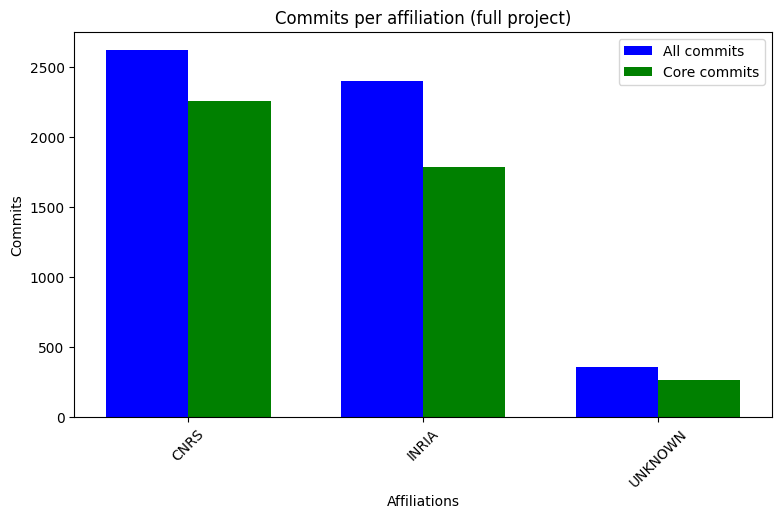

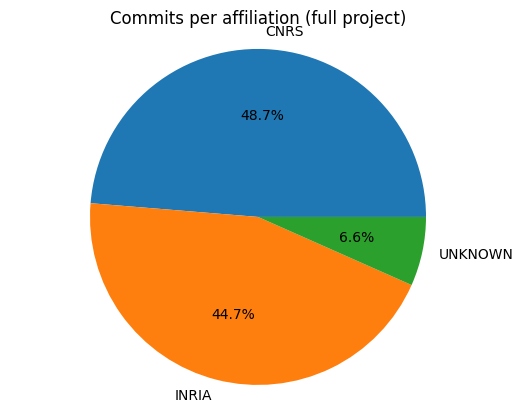

In [34]:
# Compare commits per affiliation (all and core)

result = affiliation_sum_df.merge(affiliation_core_sum_df, 
                      on=['AFFILIATION'], 
                      suffixes=['','_core'],
                      how='left')
  
# Fill missing values with zero
result.fillna(0, inplace=True)

# Reset the index if needed
result.reset_index(inplace=True)


xlabels = result["AFFILIATION"].tolist()
title = "Commits per affiliation (full project)"
xlabel = "Affiliations"
ylabel = "Commits"
values_series1 = result["Commits"].tolist()
values_series2 = result["Commits_core"].tolist()
label1 = "All commits"
label2 = "Core commits"
image_filename = "./output/"+ repository_name +"_commits_per_affiliation.png"
image_filenames['CHART_COMMITS_AFFILIATION'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, 
                          label1, label2, 
                          image_filename)

# now the same data as a pie chart

title = "Commits per affiliation (full project)"
values = affiliation_sum_df['Commits'].values
labels = affiliation_sum_df['AFFILIATION'].values

image_filename = "./output/"+ repository_name +"_pie_commits_per_affiliation.png"
image_filenames['PIE_COMMITS_AFFILIATION'] = image_filename

display_piechart(title, values, labels, image_filename)

Display the percentage of contributions per affiliation

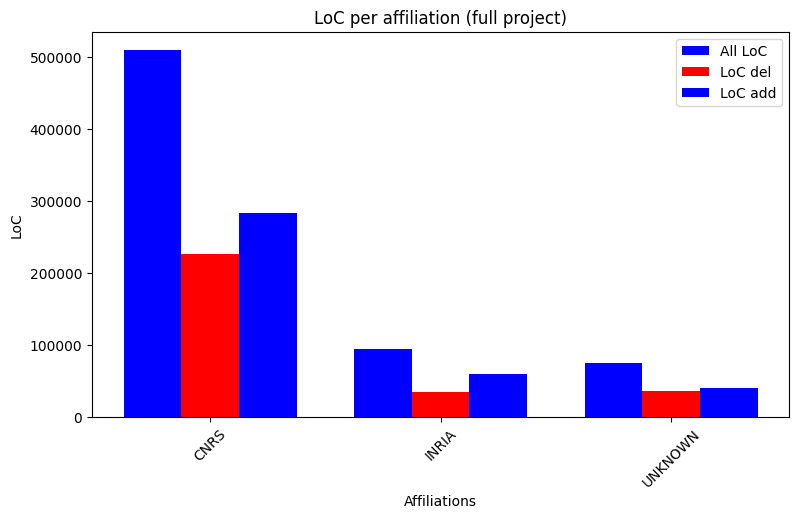

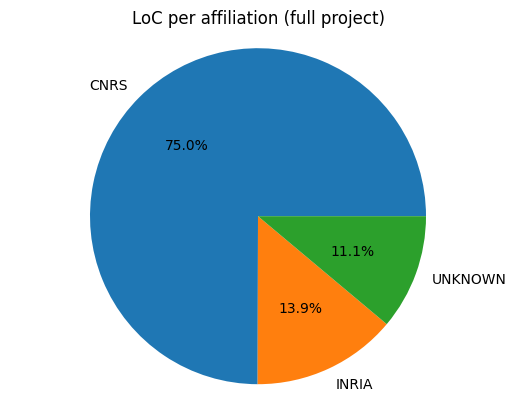

In [35]:
# Compare LoC per affiliation (all then core)

result = affiliation_sum_df.merge(affiliation_core_sum_df, 
                      on=['AFFILIATION'], 
                      suffixes=['','_core'],
                      how='left')
  
# Fill missing values with zero
result.fillna(0, inplace=True)

# Reset the index if needed
result.reset_index(inplace=True)

xlabels = result["AFFILIATION"].tolist()
title = "LoC per affiliation (full project)"
xlabel = "Affiliations"
ylabel = "LoC"
values_series1 = result["LoC total"].tolist()
values_series2 = result["LoC del"].tolist()
values_series3 = result["LoC add"].tolist()
label1 = "All LoC"
label2 = "LoC del"
label3 = "LoC add"
image_filename = "./output/"+ repository_name +"_loc_per_affiliation.png"
image_filenames['CHART_LOC_AFFILIATION'] = image_filename

display_3barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, values_series3,
                          label1, label2, label3,
                          image_filename)

# now the same data as a pie chart

title = "LoC per affiliation (full project)"
values = result['LoC total'].values
labels = result["AFFILIATION"].values

image_filename = "./output/"+ repository_name +"_pie_loc_per_affiliation.png"
image_filenames['PIE_LOC_AFFILIATION'] = image_filename

display_piechart(title, values, labels, image_filename)

In [36]:
result

,index,AFFILIATION,Commits,LoC total,LoC del,LoC add,Commits_core,LoC total_core,LoC del_core,LoC add_core
0,0,CNRS,2617,509591,226470,283121,2255,484297,218941,265356
1,1,INRIA,2400,94669,34477,60192,1782,84836,30654,54182
2,2,UNKNOWN,357,75492,35329,40163,260,74103,35002,39101


In [37]:
# export the table above as image for the report (all and core files)
result.drop('index', axis=1, inplace=True)
image_filename = "./output/"+ repository_name +"_table_affiliations_stats_full_with_core.png"
image_filenames['TABLE_AFFILIATIONS_STATS_FULL_WITH_CORE'] = image_filename

dfi.export(result.style.hide(axis='index'), image_filename, dpi=150)

In [38]:
# Compare LoC per affiliation (all)

# Filter rows based on list values
filtered_df = name_sum_df[name_sum_df['NAME'].isin(major_contributors)]
filtered_core_df = name_core_sum_df[name_core_sum_df['NAME'].isin(major_contributors)]

# filtered_core_df = filtered_core_df.sort_values('NAME')

filtered_others_df = name_sum_df[~name_sum_df['NAME'].isin(major_contributors)]
filtered_others_sum = filtered_others_df.sum()
filtered_others_sum['NAME'] = 'Others'

filtered_others_core_df = name_core_sum_df[~name_core_sum_df['NAME'].isin(major_contributors)]
filtered_others_core_sum = filtered_others_core_df.sum()
filtered_others_core_sum['NAME'] = 'Others'

filtered_df = pd.concat([filtered_df, pd.DataFrame([filtered_others_sum])], ignore_index=True)
filtered_core_df = pd.concat([filtered_core_df, pd.DataFrame([filtered_others_core_sum])], ignore_index=True)


result = filtered_df.merge(filtered_core_df, 
                      on=['NAME'], 
                      suffixes=['','_core'],
                      how='left')

# Fill missing values with zero
result.fillna(0, inplace=True)

# Reset the index if needed
result.reset_index(inplace=True)

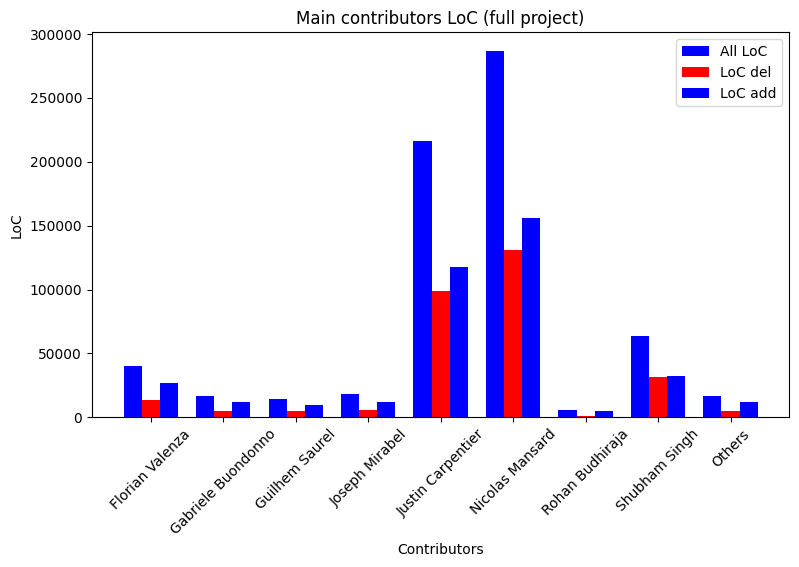

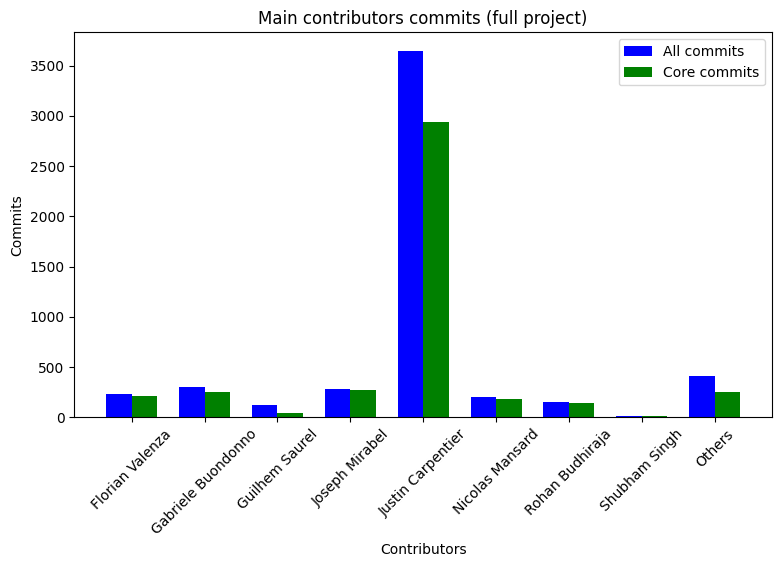

In [39]:
# display main contributors LoC and Commits for the full project

# barcharts for the LoC
xlabels = result["NAME"].tolist()
title = "Main contributors LoC (full project)"
xlabel = "Contributors"
ylabel = "LoC"
values_series1 = result["LoC total"].tolist()
values_series2 = result["LoC del"].tolist()
values_series3 = result["LoC add"].tolist()
label1 = "All LoC"
label2 = "LoC del"
label3 = "LoC add"
image_filename = "./output/"+ repository_name +"_loc_per_contributors.png"
image_filenames['CHART_MAIN_CONTRIBUTORS_LOC'] = image_filename

display_3barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, values_series3,
                          label1, label2, label3,
                          image_filename)

# now the barcharts for the commits
xlabels = result["NAME"].tolist()
title = "Main contributors commits (full project)"
xlabel = "Contributors"
ylabel = "Commits"
values_series1 = result["Commits"].tolist()
values_series2 = result["Commits_core"].tolist()
label1 = "All commits"
label2 = "Core commits"
image_filename = "./output/"+ repository_name +"_commits_per_main_.png"
image_filenames['CHART_MAIN_CONTRIBUTORS_COMMITS'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, 
                          label1, label2, 
                          image_filename)


In [40]:
result

,index,NAME,Commits,LoC total,LoC del,LoC add,Commits_core,LoC total_core,LoC del_core,LoC add_core
0,0,Florian Valenza,233,40531,13518,27013,208,38435,13369,25066
1,1,Gabriele Buondonno,305,16518,4866,11652,255,14595,4316,10279
2,2,Guilhem Saurel,120,14736,4753,9983,40,1099,520,579
3,3,Joseph Mirabel,284,17915,5656,12259,269,17698,5595,12103
4,4,Justin Carpentier,3649,216379,98984,117395,2941,206032,94086,111946
5,5,Nicolas Mansard,202,287040,130975,156065,180,284767,130630,154137
6,6,Rohan Budhiraja,152,6035,1269,4766,143,5979,1251,4728
7,7,Shubham Singh,14,63659,31349,32310,13,63420,31349,32071
8,8,Others,415,16939,4906,12033,248,11211,3481,7730


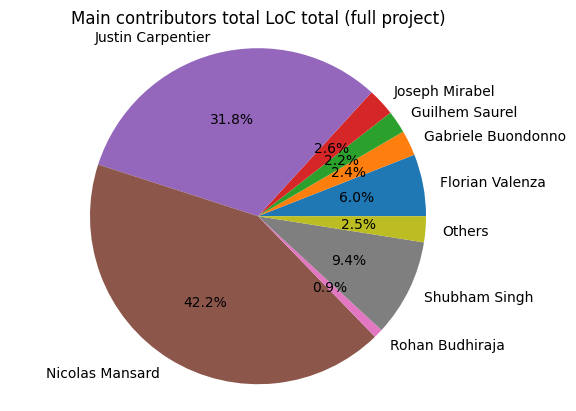

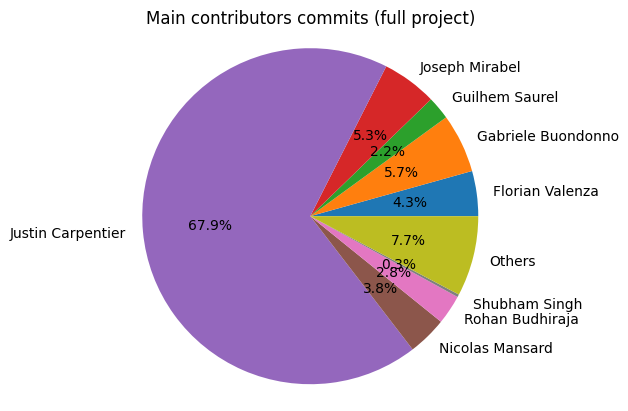

In [41]:
# now the same data as a pie chart

# LoC
title = "Main contributors total LoC total (full project)"
values = result['LoC total'].values
labels = result["NAME"].values

image_filename = "./output/"+ repository_name +"_pie_loc_per_contributors_full.png"
image_filenames['PIE_FULL_LOC_MAIN_CONTRIBUTORS'] = image_filename

display_piechart(title, values, labels, image_filename)

# Commits
title = "Main contributors commits (full project)"
values = result['Commits'].values
labels = result['NAME'].values

image_filename = "./output/"+ repository_name +"_pie_commits_per_contributors_full.png"
image_filenames['PIE_FULL_COMMITS_MAIN_CONTRIBUTORS'] = image_filename

display_piechart(title, values, labels, image_filename)

In [42]:
result

,index,NAME,Commits,LoC total,LoC del,LoC add,Commits_core,LoC total_core,LoC del_core,LoC add_core
0,0,Florian Valenza,233,40531,13518,27013,208,38435,13369,25066
1,1,Gabriele Buondonno,305,16518,4866,11652,255,14595,4316,10279
2,2,Guilhem Saurel,120,14736,4753,9983,40,1099,520,579
3,3,Joseph Mirabel,284,17915,5656,12259,269,17698,5595,12103
4,4,Justin Carpentier,3649,216379,98984,117395,2941,206032,94086,111946
5,5,Nicolas Mansard,202,287040,130975,156065,180,284767,130630,154137
6,6,Rohan Budhiraja,152,6035,1269,4766,143,5979,1251,4728
7,7,Shubham Singh,14,63659,31349,32310,13,63420,31349,32071
8,8,Others,415,16939,4906,12033,248,11211,3481,7730


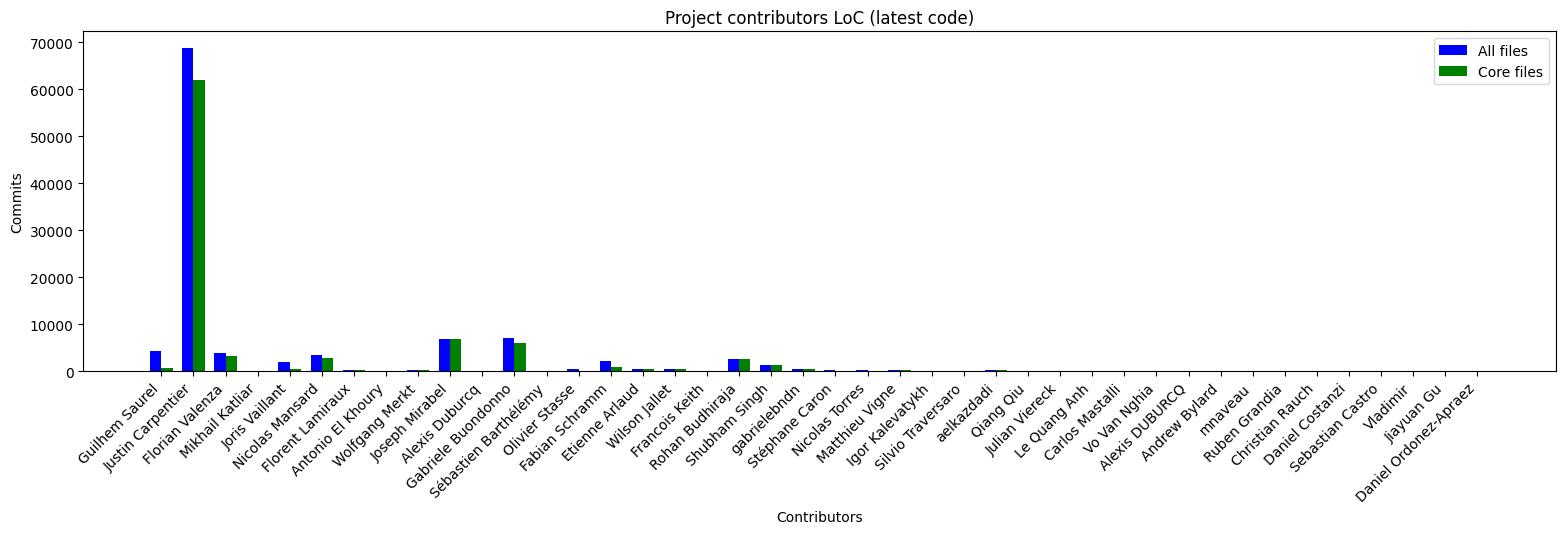

In [43]:
# Display contributors' LoC in the lastest version of the project

categories = []
values_series1 = []
values_series2 = []

for contributor in authors_contrib_dict:
    try:
        val1 = authors_loc_contrib_dict[contributor]
        val2 = authors_loc_core_contrib_dict[contributor]
        
        values_series1.append(val1)
        values_series2.append(val2)
        categories.append(contributor)
    except KeyError:
        pass

image_filename = "./output/" + repository_name + "_all_contributors_latest_code_loc.png"
image_filenames['CHART_LATEST_LOC_ALL_CONTRIBUTORS'] = image_filename

display_scalable_2barcharts_compare('Project contributors LoC (latest code)',
                                    categories, 'Contributors', 'Commits',
                                    values_series1, values_series2,
                                    'All files', 'Core files',
                                    image_filename)


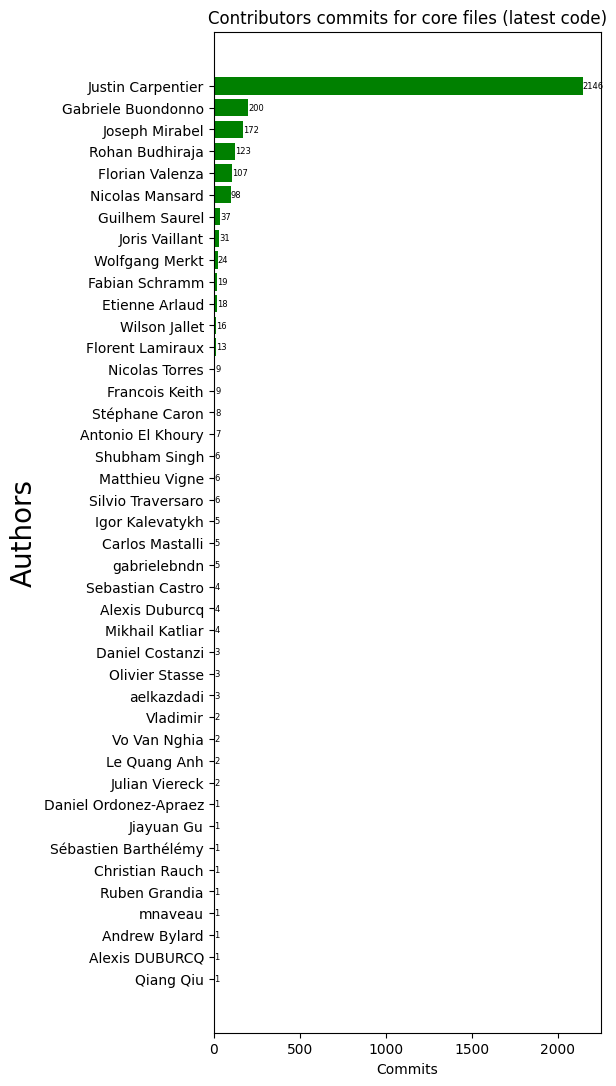

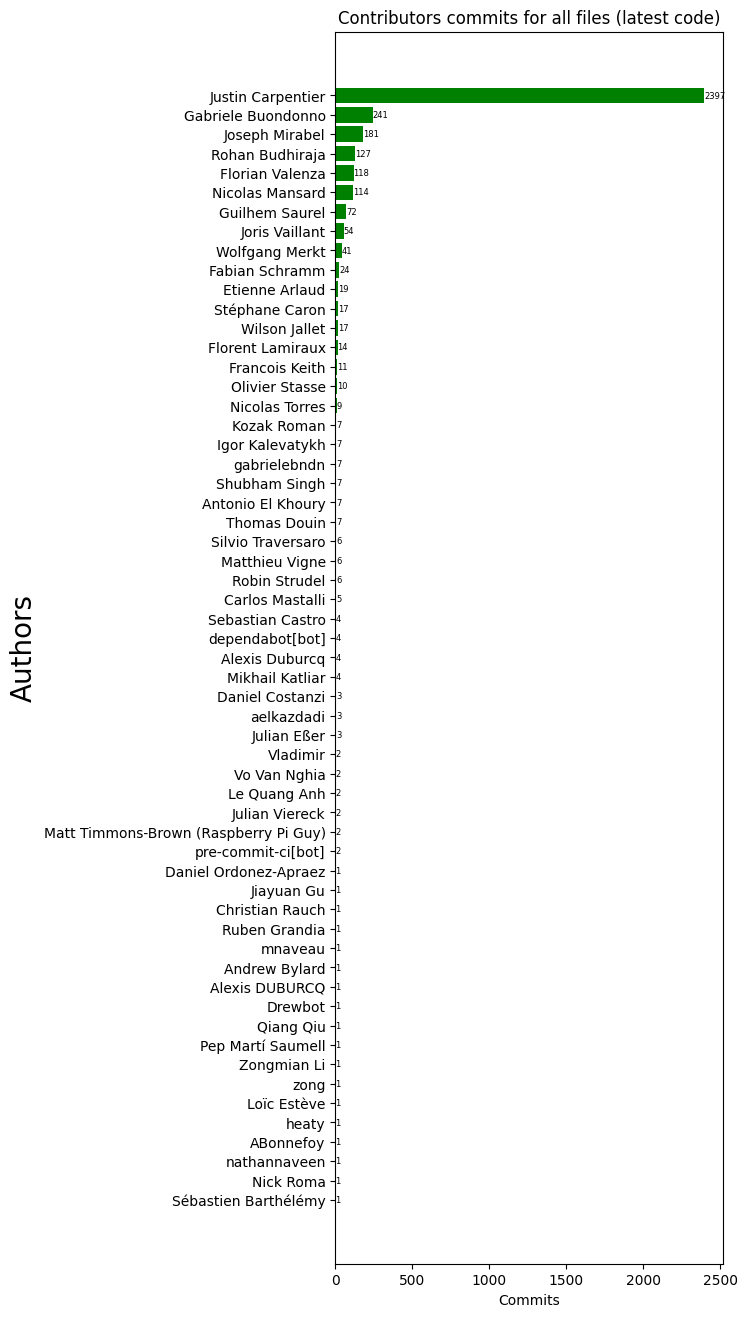

In [44]:
# display commits for latest code

sorted_dict = dict(sorted(authors_core_contrib_dict.items(), key=lambda item: item[1], reverse=False))

# Extracting keys and values from the dictionary
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

image_filename = "./output/" + repository_name + "_vert_chart_commits_core_files.png"
image_filenames['CHART_LATEST_CORE_COMMITS_ALL_CONTRIBUTORS'] = image_filename

display_vertical_barchart('Contributors commits for core files (latest code)', 
                               keys, 'Commits', 'Authors', 
                               values,
                               label1,
                               image_filename)


sorted_dict = dict(sorted(authors_contrib_dict.items(), key=lambda item: item[1], reverse=False))

# Extracting keys and values from the dictionary
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

image_filename = "./output/" + repository_name + "_vert_chart_commits_all_files.png"
image_filenames['CHART_LATEST_COMMITS_ALL_CONTRIBUTORS'] = image_filename

display_vertical_barchart('Contributors commits for all files (latest code)', 
                               keys, 'Commits', 'Authors', 
                               values,
                               label1,
                               image_filename)



missing commits 0
missing commits 0
missing commits 0


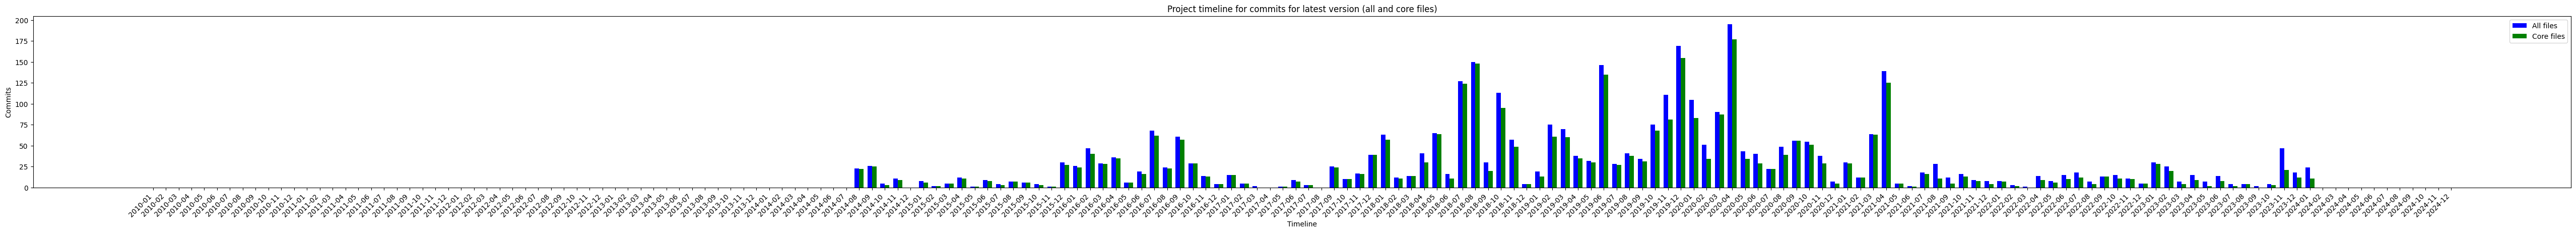

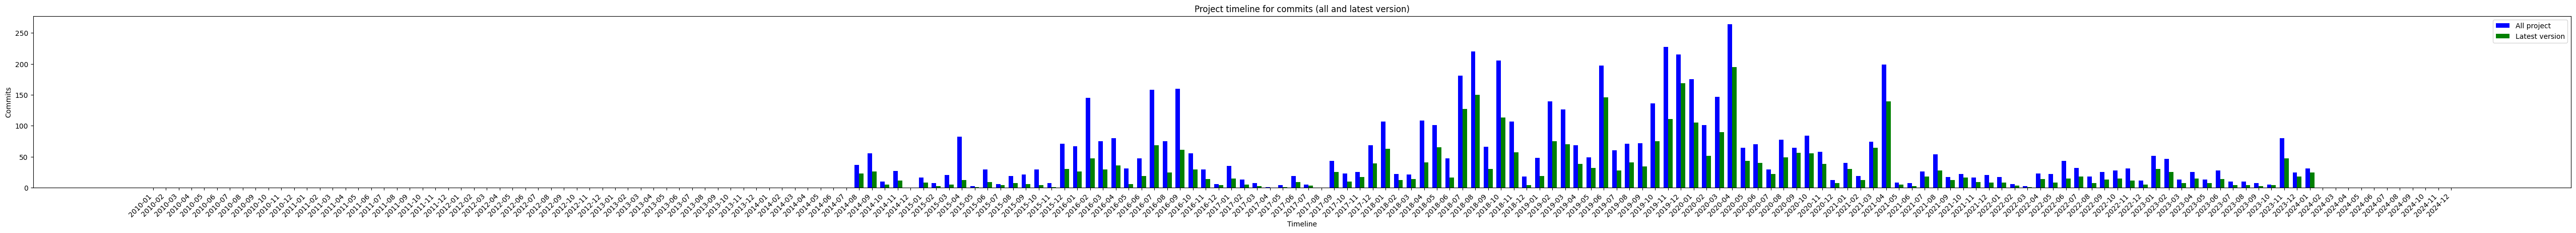

In [45]:
# Now display the timeline for commits

final_core_commits_timeline = {}
final_commits_timeline = {}
commits_timeline = {}
core_commits_timeline = {}
categories = []

for year in range(2010,2025):
    for month in range(1,13):
        kwd=f"{year}-{month:02d}"
        final_core_commits_timeline.setdefault(kwd, 0)
        final_commits_timeline.setdefault(kwd, 0)
        commits_timeline.setdefault(kwd, 0)
        core_commits_timeline.setdefault(kwd, 0)
        categories.append(kwd)

core_commit_list = list(filter(
    lambda commit: any(file.get('filename', '').startswith(tuple(core_prefixes)) for file in commit.get('files', [])),
    all_commits_dict
))

missing_commits=0

for commitid in final_core_commit_list:
    try:
        commit = commit_dict[commitid]
        commit_date = datetime.strptime(commit['commit']['author']['date'], '%Y-%m-%dT%H:%M:%SZ').date()
        key=f"{commit_date.year}-{commit_date.month:02d}"
        final_core_commits_timeline[key] += 1
    except KeyError:
        missing_commits += 1
        pass

print(f"missing commits {missing_commits}")
missing_commits=0

for commitid in final_commit_list:
    try:
        commit = commit_dict[commitid]
        commit_date = datetime.strptime(commit['commit']['author']['date'], '%Y-%m-%dT%H:%M:%SZ').date()
        key=f"{commit_date.year}-{commit_date.month:02d}"
        final_commits_timeline[key] += 1
    except KeyError:
        #print ("Error 2 with commit ID : " + commitid)
        #key=f"{commit_date.year}-{commit_date.month:02d}"
        #print(key)
        missing_commits += 1
        pass

print(f"missing commits {missing_commits}")
missing_commits=0

sorted_final_core_commits_timeline = OrderedDict(sorted(final_core_commits_timeline.items()))
sorted_final_commits_timeline = OrderedDict(sorted(final_commits_timeline.items()))

for commit in all_commits_dict:
    try:
        commit_date = datetime.strptime(commit['commit']['author']['date'], '%Y-%m-%dT%H:%M:%SZ').date()
        key=f"{commit_date.year}-{commit_date.month:02d}"
        commits_timeline[key] += 1
    except KeyError:
        missing_commits += 1
        pass
        
sorted_commits_timeline = OrderedDict(sorted(commits_timeline.items()))

print(f"missing commits {missing_commits}")
missing_commits=0

for commit in core_commit_list:
    try:
        commit_date = datetime.strptime(commit['commit']['author']['date'], '%Y-%m-%dT%H:%M:%SZ').date()
        key=f"{commit_date.year}-{commit_date.month:02d}"
        core_commits_timeline[key] += 1
    except KeyError:
        missing_commits += 1
        pass
        
# sorted_core_commits_timeline = OrderedDict(sorted(core_commits_timeline.items()))
# quarterly_sum = sorted_core_commits_timeline_df.groupby(sorted_core_commits_timeline_df['date'].dt.to_period('Q')).sum()
# print(f"missing commits {missing_commits}")




image_filename = "./output/" + repository_name + "_timeline_latest_code_commits.png"
image_filenames['TIMELINE_LATEST_COMMITS_ALL_CORE'] = image_filename
display_scalable_2barcharts_compare('Project timeline for commits for latest version (all and core files)',
                                    categories, 'Timeline', 'Commits',
                                    sorted_final_commits_timeline.values(), sorted_final_core_commits_timeline.values(),
                                    'All files', 'Core files',
                                    image_filename)


image_filename = "./output/" + repository_name + "_timeline_all_latest_commits.png"
image_filenames['TIMELINE_COMMITS_ALL_LATEST'] = image_filename
display_scalable_2barcharts_compare('Project timeline for commits (all and latest version)',
                                    categories, 'Timeline', 'Commits',
                                    sorted_commits_timeline.values(), sorted_final_commits_timeline.values(),
                                    'All project', 'Latest version',
                                    image_filename)



# Latest code images

In [48]:
# final_commit_list

In [49]:
mask = all_commits_dict_df['sha'].isin(final_commit_list)
latest_all_commits_dict_df = all_commits_dict_df[mask]
latest_all_commits_dict_df

,sha,parents,files,LOGIN,author.id,author.node_id,author.avatar_url,author.gravatar_id,author.url,author.html_url,...,commit.verification.payload,stats.total,stats.additions,stats.deletions,DATE,IS_MERGE,has_core_contrib,AFFILIATION,NAME,EMAIL
0,0caf0ca4d07e63834cdc420c703993662c59e01b,[{'sha': 'eb71f1c80d5ffcada086ecce577adc1a7df9...,[{'sha': 'a7ec90e329053f2a184c2cf84efcd8c6fc0d...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree cb249fde596a3d0228623ca6120f49898fb50acf\...,5,4,1,2024-01-23,False,False,INRIA,Joris Vaillant,joris.vaillant@inria.fr
1,eb71f1c80d5ffcada086ecce577adc1a7df9839a,[{'sha': '0fb9de95a9f448014aafeb43378bb566478f...,[{'sha': 'd77831862f5336a5741383931355834a56b3...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree 233b90ee935b518bc1996d9b82a4fde066c655be\...,2,1,1,2024-01-23,False,False,INRIA,Joris Vaillant,joris.vaillant@inria.fr
3,4cc7bc88e4c6ad4b0c8bf711dc042429da2e974b,[{'sha': '97a00a983e66fc0a58667f9671e2d806ba9b...,[{'sha': 'b9405b47b94f7bc6f450475e57008c409b50...,dependabot[bot],49699333.0,MDM6Qm90NDk2OTkzMzM=,https://avatars.githubusercontent.com/in/29110...,,https://api.github.com/users/dependabot%5Bbot%5D,https://github.com/apps/dependabot,...,tree 5e87484f393bb48322dc6662839bdcd593a20804\...,6,3,3,2024-01-22,False,False,UNKNOWN,dependabot[bot],49699333+dependabot[bot]@users.noreply.github.com
5,acaec064ddebbbc0dc4468a55da7c6cc3d02258c,[{'sha': '0d1e2eb8958b038be04106343717ac9408a0...,[{'sha': 'e009da0a3cf0b55585a90496ec7e30306a63...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree f87ea764edf342acd6ceb1fb8a80f589cada8fbd\...,24,16,8,2024-01-15,False,True,INRIA,Joris Vaillant,joris.vaillant@inria.fr
6,0d1e2eb8958b038be04106343717ac9408a05e64,[{'sha': 'd0176ffa5d4151df059a98d1bd63c83a46da...,[{'sha': '5de1fc771e8c95e42e727469e5fb84e8609d...,jorisv,778707.0,MDQ6VXNlcjc3ODcwNw==,https://avatars.githubusercontent.com/u/778707...,,https://api.github.com/users/jorisv,https://github.com/jorisv,...,tree 813fd0e88a6888eb48c6a5b648cf9b3344b2b044\...,1,1,0,2024-01-15,False,False,INRIA,Joris Vaillant,joris.vaillant@inria.fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6462,c62f794db067637e46423fd09ccbb67b65787f21,[{'sha': 'd451a70dd1c28a5822fff329e6160e9c8198...,[{'sha': 'a26dc98b0a8639131143f737369efba7ff99...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,53,53,0,2014-08-20,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6463,d451a70dd1c28a5822fff329e6160e9c81987fd8,[{'sha': 'a632858dd7a79002ba128470cbe975336afa...,[{'sha': '0b63c9026a08bc5ee91b067eddde725fa7d9...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,197,153,44,2014-08-20,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6464,a632858dd7a79002ba128470cbe975336afa127c,[{'sha': '36e57606d3e718e0987efd118966904bda85...,[{'sha': 'cdcaae9cb28882a45ab359e32f5a94f59519...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,163,137,26,2014-08-20,False,True,CNRS,Nicolas Mansard,nmansard@laas.fr
6466,2e0cffc4c56abae78f00250954a5ceb009ffa90e,[{'sha': 'c1678b075fd9a1f257b0933b4adebdfa46e0...,[{'sha': '367d52393f33bb9d6c7a68b3ceda1e8cd51f...,nmansard,458248.0,MDQ6VXNlcjQ1ODI0OA==,https://avatars.githubusercontent.com/u/458248...,,https://api.github.com/users/nmansard,https://github.com/nmansard,...,None,2041,2038,3,2014-08-18,False,True,CNRS,Nicolas

In [50]:
# create dataframe from the commit-LoC dictionnary just created 
df = pd.DataFrame.from_dict(final_commits_loc_dict, orient='index', columns=['loc_latest'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'sha'}, inplace=True)
df

,sha,loc_latest
0,30bf4e909483a131992466aa6f392e39c279d245,146
1,5a5abdecf2de9b05e2dd870b55750978e0ea7cbb,2
2,a092b4290c7f51c4354869abd1070a9072898bd3,1
3,b4c4215e1b68ca098319960e018e6a4d1ad5fdcf,1
4,1de6a50e3b9bed28155cecc96f476cf9a14a9883,1
...,...,...
3581,532ebe7aab250a6f70a7f5f0f1af3c3770f70f4e,1
3582,db8fe0add7d10ea31ff13aa677e30fcc3b569e42,1
3583,3e5604fea8838eba59c5d1f94515fc9c602bff4a,16
3584,29c581108e1b1a2a7fb4deadf7d422b53ae26f75,4


In [51]:
# create a new dataframe that merge the loc_latest column in the table with the dataframe of the commits for the latest code
latest_merged_df = pd.merge(latest_all_commits_dict_df, df[['sha', 'loc_latest']], on='sha', how='left')

In [52]:
# now create merged dataframes to count the LoC ops for each user and affiliation
latest_sum_df = latest_merged_df.loc[~latest_merged_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION','NAME']).agg(
    loc_latest=('loc_latest', 'sum'),
).reset_index()

# count the number of commits for each user and affiliation
latest_grouped_counts = latest_merged_df.loc[~latest_merged_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION', 'NAME']).size().reset_index(name='count')

# merge the count column in the previous table
latest_sum_df.insert(2, 'count', latest_grouped_counts['count'])

# group by affiliation only
latest_affiliation_sum_df = latest_sum_df.groupby(['AFFILIATION']).agg(
    count=('count', 'sum'),
    loc_latest=('loc_latest', 'sum')
).reset_index()

# group by name only
latest_name_sum_df = latest_sum_df.groupby(['NAME']).agg(
    count=('count', 'sum'),
    loc_latest=('loc_latest', 'sum')
).reset_index()

# Now rename columns before display (all the columns are about latest code)
latest_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)
latest_affiliation_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)
latest_name_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)

##
## Now compute the same stats for core commits only
##

core_latest_merged_df = latest_merged_df[latest_merged_df['has_core_contrib'] == True].loc[~latest_merged_df['IS_MERGE']]

# count the number of commits for each user and affiliation
core_latest_sum_df = core_latest_merged_df.loc[~core_latest_merged_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION','NAME']).agg(
    loc_latest=('loc_latest', 'sum'),
).reset_index()

# count the number of commits for each user and affiliation
core_latest_grouped_counts = core_latest_merged_df.loc[~core_latest_merged_df['IS_MERGE']].groupby(['LOGIN', 'AFFILIATION', 'NAME']).size().reset_index(name='count')

# merge the count column in the previous table
core_latest_sum_df.insert(2, 'count', core_latest_grouped_counts['count'])

# group by affiliation only
core_latest_affiliation_sum_df = core_latest_sum_df.groupby(['AFFILIATION']).agg(
    count=('count', 'sum'),
    loc_latest=('loc_latest', 'sum')
).reset_index()

# group by name only
core_latest_name_sum_df = core_latest_sum_df.groupby(['NAME']).agg(
    count=('count', 'sum'),
    loc_latest=('loc_latest', 'sum')
).reset_index()

# Now rename columns before display (all the columns are about latest code)
core_latest_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)
core_latest_affiliation_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)
core_latest_name_sum_df.rename(columns={"count": "Commits",
                       "loc_latest": "LoC"
                      }, inplace=True)

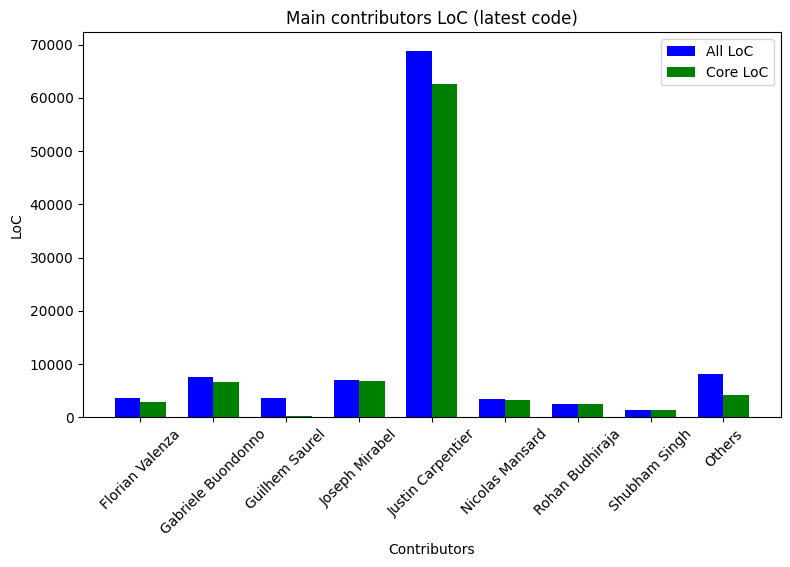

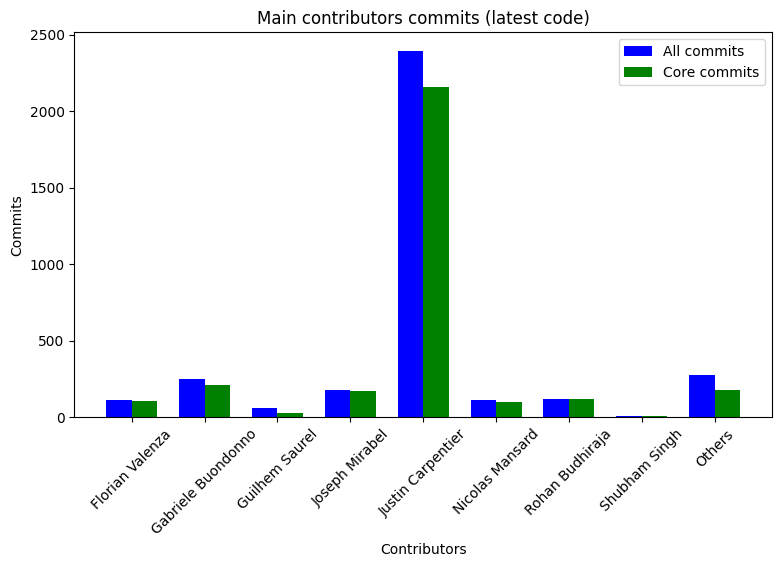

In [53]:
# Compare LoC per affiliation (latest code)

# Filter rows based on list values
filtered_df = latest_name_sum_df[latest_name_sum_df['NAME'].isin(major_contributors)]
filtered_core_df = core_latest_name_sum_df[core_latest_name_sum_df['NAME'].isin(major_contributors)]

filtered_others_df = latest_name_sum_df[~latest_name_sum_df['NAME'].isin(major_contributors)]
filtered_others_sum = filtered_others_df.sum()
filtered_others_sum['NAME'] = 'Others'

filtered_others_core_df = core_latest_name_sum_df[~core_latest_name_sum_df['NAME'].isin(major_contributors)]
filtered_others_core_sum = filtered_others_core_df.sum()
filtered_others_core_sum['NAME'] = 'Others'

filtered_df = pd.concat([filtered_df, pd.DataFrame([filtered_others_sum])], ignore_index=True)
filtered_core_df = pd.concat([filtered_core_df, pd.DataFrame([filtered_others_core_sum])], ignore_index=True)

result = filtered_df.merge(filtered_core_df, 
                      on=['NAME'], 
                      suffixes=['','_core'],
                      how='left')

# Fill missing values with zero
result.fillna(0, inplace=True)

# Reset the index if needed
result.reset_index(inplace=True)

xlabels = result["NAME"].tolist()
title = "Main contributors LoC (latest code)"
xlabel = "Contributors"
ylabel = "LoC"
values_series1 = result["LoC"].tolist()
values_series2 = result["LoC_core"].tolist()
label1 = "All LoC"
label2 = "Core LoC"
image_filename = "./output/"+ repository_name +"_loc_per_contributors_latest.png"
image_filenames['CHART_LATEST_LOC_MAIN_CONTRIBUTORS'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2,
                          label1, label2,
                          image_filename)

xlabels = result["NAME"].tolist()
title = "Main contributors commits (latest code)"
xlabel = "Contributors"
ylabel = "Commits"
values_series1 = result["Commits"].tolist()
values_series2 = result["Commits_core"].tolist()
label1 = "All commits"
label2 = "Core commits"
image_filename = "./output/"+ repository_name +"_commits_per_main_.png"
image_filenames['CHART_LATEST_COMMITS_MAIN_CONTRIBUTORS'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, 
                          label1, label2, 
                          image_filename)


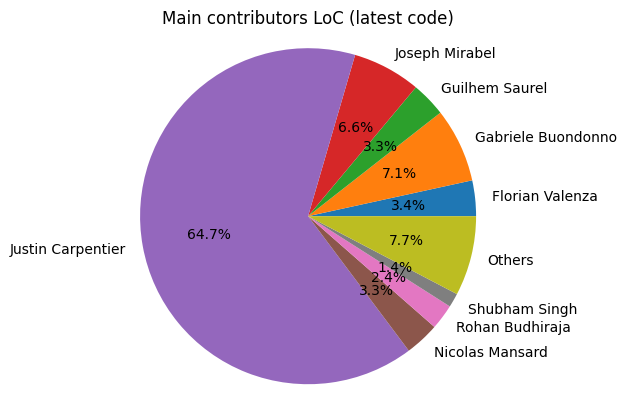

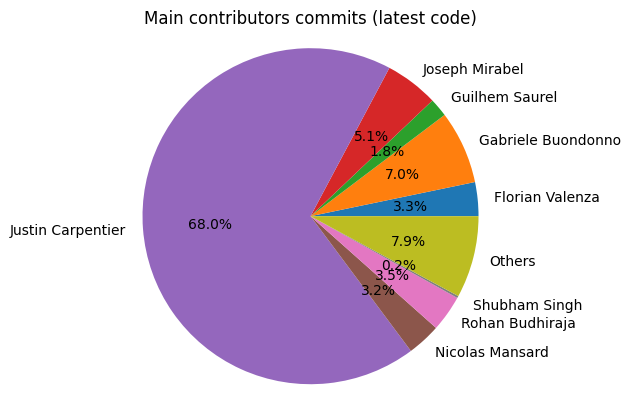

In [54]:
# now the same data as a pie chart

title = "Main contributors LoC (latest code)"
values = result['LoC'].values
labels = result["NAME"].values

image_filename = "./output/"+ repository_name +"_pie_loc_per_contributors_latest.png"
image_filenames['PIE_LATEST_LOC_MAIN_CONTRIBUTORS'] = image_filename

display_piechart(title, values, labels, image_filename)

# now the same data as a pie chart

title = "Main contributors commits (latest code)"
values = result['Commits'].values
labels = result['NAME'].values

image_filename = "./output/"+ repository_name +"_pie_commits_per_contributors_latest.png"
image_filenames['PIE_LATEST_COMMITS_MAIN_CONTRIBUTORS'] = image_filename

display_piechart(title, values, labels, image_filename)

In [55]:
result

,index,NAME,Commits,LoC,Commits_core,LoC_core
0,0,Florian Valenza,115,3645,107,2933
1,1,Gabriele Buondonno,248,7600,208,6602
2,2,Guilhem Saurel,63,3564,29,198
3,3,Joseph Mirabel,181,6985,172,6852
4,4,Justin Carpentier,2396,68891,2159,62566
5,5,Nicolas Mansard,114,3525,100,3211
6,6,Rohan Budhiraja,123,2589,119,2561
7,7,Shubham Singh,7,1438,7,1438
8,8,Others,278,8162,180,4252


In [56]:
# export the table above as image for the report
result.drop('index', axis=1, inplace=True)
result.rename(columns={"Commits_core": "Commits Core",
                       "LoC_core": "LoC Core"
                      }, inplace=True)
image_filename = "./output/"+ repository_name +"_table_contributors_stats_latest.png"
image_filenames['TABLE_CONTRIBUTORS_STATS_LATEST'] = image_filename

dfi.export(result.style.hide(axis='index'), image_filename, dpi=150)

In [57]:
# handle case when less affiliations in core than in all

# Identify unique AFFILIATION values in both DataFrames
unique_aff_all = set(latest_affiliation_sum_df['AFFILIATION'])
unique_aff_core = set(core_latest_affiliation_sum_df['AFFILIATION'])
# Find AFFILIATION values that are in all but not in core
missing_aff = unique_aff_all - unique_aff_core
# Create new rows with missing AFFILIATION values in core, setting all other column values to zero
new_rows = pd.DataFrame({'AFFILIATION': list(missing_aff)})
for col in core_latest_affiliation_sum_df.columns:
    if col != 'AFFILIATION':
        new_rows[col] = 0
# Concatenate the original df2 with the newly created rows
core_latest_affiliation_sum_df = pd.concat([core_latest_affiliation_sum_df, new_rows], ignore_index=True)
# Reset the index if needed
core_latest_affiliation_sum_df.reset_index(drop=True, inplace=True)

# sort so that same order
latest_affiliation_sum_df = latest_affiliation_sum_df.sort_values('AFFILIATION')
core_latest_affiliation_sum_df = core_latest_affiliation_sum_df.sort_values('AFFILIATION')

In [58]:
core_latest_affiliation_sum_df

,AFFILIATION,Commits,LoC
0,CNRS,1417,42853
1,INRIA,1469,42592
2,UNKNOWN,195,5168


In [59]:
latest_affiliation_sum_df

,AFFILIATION,Commits,LoC
0,CNRS,1566,49661
1,INRIA,1710,50950
2,UNKNOWN,249,5788


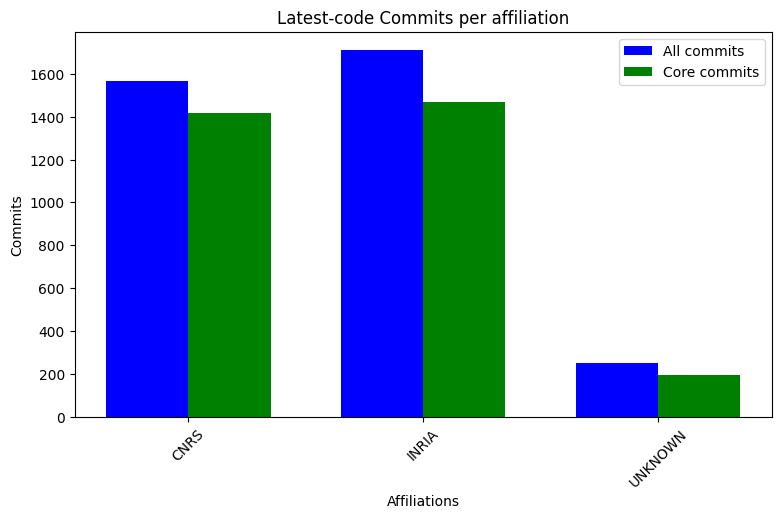

,index,AFFILIATION,Commits,LoC,Commits_core,LoC_core
0,0,CNRS,1566,49661,1417,42853
1,1,INRIA,1710,50950,1469,42592
2,2,UNKNOWN,249,5788,195,5168


In [60]:
# Compare commits per affiliation (all and core)
result = latest_affiliation_sum_df.merge(core_latest_affiliation_sum_df, 
                      on=['AFFILIATION'], 
                      suffixes=['','_core'],
                      how='left')
  
# Fill missing values with zero
result.fillna(0, inplace=True)

# Reset the index if needed
result.reset_index(inplace=True)

xlabels = result["AFFILIATION"].tolist()
title = "Latest-code Commits per affiliation"
xlabel = "Affiliations"
ylabel = "Commits"
values_series1 = latest_affiliation_sum_df["Commits"].tolist()
values_series2 = core_latest_affiliation_sum_df["Commits"].tolist()
label1 = "All commits"
label2 = "Core commits"

image_filename = "./output/"+ repository_name +"_latest_commits_per_affiliation.png"
image_filenames['CHART_LATEST_COMMITS_AFFILIATION'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, 
                          label1, label2, 
                          image_filename)

result


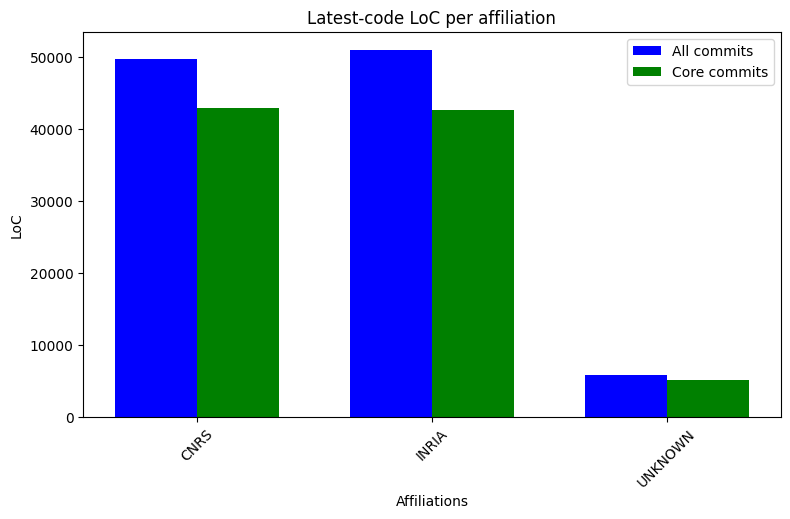

In [61]:
# Compare LoC per affiliation (all then core)

#result = affiliation_sum_df.merge(latest_affiliation_sum_df, 
#                      on=['AFFILIATION'], 
#                      suffixes=['','_core'],
#                      how='left')
  
# Fill missing values with zero
#result.fillna(0, inplace=True)

# Reset the index if needed
#result.reset_index(inplace=True)


xlabels = result["AFFILIATION"].tolist()
title = "Latest-code LoC per affiliation"
xlabel = "Affiliations"
ylabel = "LoC"
values_series1 = latest_affiliation_sum_df["LoC"].tolist()
values_series2 = core_latest_affiliation_sum_df["LoC"].tolist()
label1 = "All commits"
label2 = "Core commits"
image_filename = "./output/"+ repository_name +"_latest_loc_per_affiliation.png"
image_filenames['CHART_LATEST_LOC_AFFILIATION'] = image_filename

display_2barcharts_compare(title, xlabels, 
                          xlabel, ylabel, 
                          values_series1, values_series2, 
                          label1, label2, 
                          image_filename)


In [62]:
result

,index,AFFILIATION,Commits,LoC,Commits_core,LoC_core
0,0,CNRS,1566,49661,1417,42853
1,1,INRIA,1710,50950,1469,42592
2,2,UNKNOWN,249,5788,195,5168


In [63]:
result.drop('index', axis=1, inplace=True)
result

,AFFILIATION,Commits,LoC,Commits_core,LoC_core
0,CNRS,1566,49661,1417,42853
1,INRIA,1710,50950,1469,42592
2,UNKNOWN,249,5788,195,5168


In [64]:
image_filename = "./output/"+ repository_name +"_table_latest_affiliations_info.png"
image_filenames['TABLE_LATEST_INFO_AFFILIATION'] = image_filename

dfi.export(result.style.hide(axis='index'), image_filename, dpi=150)

## Generate template file for contributors affiliations for this project

Generate a file with the timeframe (start,end) for the contributions (commits date) to this project. This can be used to generate the affiliations' file to be used for employers attribution.


In [65]:
csv_contrib_affiliation_filename = "contributors_affiliation_" + repository_name + ".csv"

data_dict = {}

for commit in all_commits_dict:
    key = commit['commit']['author']['name']
    item = data_dict.get(key)
    if item is None:
        item = [
            commit['commit']['author']['name'],
            commit['commit']['author']['email'],
            "",
            "",
            0,
            commit['commit']['author']['date'],
            commit['commit']['author']['date'],
            commit['stats']['total'],
            commit['stats']['additions'],
            commit['stats']['deletions'],
            0,
            0,
            0
        ]
        try:
            item[2] = commit['author']['login']
            item[3] = commit['author']['id']
        except (KeyError, TypeError):
            pass

    item[4] = item[4] + 1
    item[7] = item[7] + commit['stats']['total']
    item[8] = item[8] + commit['stats']['additions']
    item[9] = item[9] + commit['stats']['deletions']
    if commit['commit']['author']['date'] <= item[5]:
        item[5] = commit['commit']['author']['date']
    if commit['commit']['author']['date'] >= item[6]:
        item[6] = commit['commit']['author']['date']

    for file in commit.get('files', []):
        if file.get('filename', '').startswith(tuple(core_prefixes)):
            item[10] = item[10] + file.get('changes')
            item[11] = item[11] + file.get('additions')
            item[12] = item[12] + file.get('deletions')

    data_dict[key] = item


title = ["NAME",
         "EMAIL",
         "LOGIN",
         "GHID",
         "COMMITS",
         "START",
         "END",
         "LOC TOTAL",
         "LOC ADD",
         "LOC DEL",
         "CORE LOC TOTAL",
         "CORE LOC ADD",
         "CORE LOC DEL",
        ]

csv_items = list(data_dict.values())

# convert date (no time)
for csv_item in csv_items:
    csv_item[5] = datetime.strptime(csv_item[5], "%Y-%m-%dT%H:%M:%SZ").date();
    csv_item[6] = datetime.strptime(csv_item[6], "%Y-%m-%dT%H:%M:%SZ").date();
   
with open(csv_contrib_affiliation_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(title)
    writer.writerows(csv_items)

print("Generated the affiliation template file " + csv_contrib_affiliation_filename)

Generated the affiliation template file contributors_affiliation_pinocchio.csv


## Generating Markdown Report

First some generic function to create the markdown tables to include in the final report.

In [66]:
def getMajorContributorsTable(contributors):
    str = "| Main contributors |\n" + "| ----------------- |\n"

    for contrib in contributors:
        str += "|" + contrib + "|\n"

    return str

def getMergersTable(mergers):
    str = "| Contributor | Renammed as |\n" + "| -------- | --------- |\n"

    for index, row in mergers_df.iterrows():
        str += "|" + row['name'] + "|" + row['rename'] + "|\n"

    return str

def getCoreFoldersTable(folders):
    str = "| Folders |\n" + "| ----------------- |\n"

    for folder in folders:
        str += "|" + folder + "|\n"

    return str

def getAffiliationsTable(affiliations):
    str = "| Name | Affiliation | Start | End |\n" + "| -------- | --------- | --------- | --------- |\n"

    for index, row in affiliations.iterrows():
        str += "|" + row['NAME'] + "|" + row['AFFILIATION'] + "|" + row['START'] + "|" + row['END'] + "|\n"

    return str



Now read the template report, replace the template text with the relevant data and save as a new report. PDF generation should be done from any Markdown app (Python libraries are currently too limited).

This also allows to add new hindsight on the data/charts being added in the report.

In [67]:
from datetime import date

filedata = None

# Read in the file
with open('./data/report_template.md', 'r') as file:
  filedata = file.read()

today = str(date.today())
project_url = "https://github.com/" + organisation + "/" + repository_name

# Replace configuration strings
filedata = filedata.replace('PROJECT_NAME', repository_name)
filedata = filedata.replace('ORGANIZATION', organisation)
filedata = filedata.replace('PROJECT_URL', project_url)
filedata = filedata.replace('REPORT_DATE', today)

filedata = filedata.replace('GHSTATS_URL', notebook_url)

# General info
filedata = filedata.replace('NUMBER_COMMITS_WITH_MERGE', str(NUMBER_COMMITS_WITH_MERGE))
filedata = filedata.replace('NUMBER_MERGE', str(NUMBER_MERGE))
filedata = filedata.replace('NUMBER_COMMITS', str(NUMBER_COMMITS))
filedata = filedata.replace('NUMBER_CONTRIBUTORS', str(NUMBER_CONTRIBUTORS))
filedata = filedata.replace('NUMBER_MAIN_CONTRIBUTORS', str(NUMBER_MAIN_CONTRIBUTORS))

filedata = filedata.replace('LATEST_COMMIT_SHA', str(most_recent_commit['sha']))
filedata = filedata.replace('LATEST_COMMIT_DATE', str(most_recent_commit['DATE']))

filedata = filedata.replace('LOCAL_REPO_COMMIT_SHA', str(local_repo_commit_sha))
filedata = filedata.replace('LOCAL_REPO_COMMIT_DATE', str(local_repo_commit_date))

# Contributors accounts (main, merge)
filedata = filedata.replace('MAIN_CONTRIBUTORS_TABLE', getMajorContributorsTable(major_contributors) )
filedata = filedata.replace('ACCOUNT_MERGING_TABLE', getMergersTable(mergers_df) )
# use the filtered DF with only people that contributed to this project
filedata = filedata.replace('ACCOUNT_AFFILIATION_TABLE', getAffiliationsTable(filtered_affiliation_df) )

# Core folders table
filedata = filedata.replace('CORE_FOLDERS_TABLE', getCoreFoldersTable(core_prefixes) )

# Full project

## Main contributors

filedata = filedata.replace('CHART_MAIN_CONTRIBUTORS_COMMITS', image_filenames['CHART_MAIN_CONTRIBUTORS_COMMITS'])
filedata = filedata.replace('CHART_MAIN_CONTRIBUTORS_LOC', image_filenames['CHART_MAIN_CONTRIBUTORS_LOC'])

filedata = filedata.replace('PIE_FULL_COMMITS_MAIN_CONTRIBUTORS', image_filenames['PIE_FULL_COMMITS_MAIN_CONTRIBUTORS'])
filedata = filedata.replace('PIE_FULL_LOC_MAIN_CONTRIBUTORS', image_filenames['PIE_FULL_LOC_MAIN_CONTRIBUTORS'])

filedata = filedata.replace('TABLE_CONTRIBUTORS_STATS_FULL', image_filenames['TABLE_CONTRIBUTORS_STATS_FULL'])

## Affiliation

filedata = filedata.replace('CHART_COMMITS_AFFILIATION', image_filenames['CHART_COMMITS_AFFILIATION'])
filedata = filedata.replace('CHART_LOC_AFFILIATION', image_filenames['CHART_LOC_AFFILIATION'])

filedata = filedata.replace('PIE_COMMITS_AFFILIATION', image_filenames['PIE_COMMITS_AFFILIATION'])
filedata = filedata.replace('PIE_LOC_AFFILIATION', image_filenames['PIE_LOC_AFFILIATION'])

# table with commits/LoC per affiliation on all/core files, whole project
# filedata = filedata.replace('TABLE_AFFILIATIONS_STATS_FULL', image_filenames['TABLE_AFFILIATIONS_STATS_FULL'])
filedata = filedata.replace('TABLE_AFFILIATIONS_STATS_FULL_WITH_CORE', image_filenames['TABLE_AFFILIATIONS_STATS_FULL_WITH_CORE'])


# Latest code

## affiliations

filedata = filedata.replace('CHART_LATEST_COMMITS_AFFILIATION', image_filenames['CHART_LATEST_COMMITS_AFFILIATION'])
filedata = filedata.replace('CHART_LATEST_LOC_AFFILIATION', image_filenames['CHART_LATEST_LOC_AFFILIATION'])

filedata = filedata.replace('TABLE_LATEST_INFO_AFFILIATION', image_filenames['TABLE_LATEST_INFO_AFFILIATION'])

# main contributors

filedata = filedata.replace('CHART_LATEST_COMMITS_MAIN_CONTRIBUTORS', image_filenames['CHART_LATEST_COMMITS_MAIN_CONTRIBUTORS'])
filedata = filedata.replace('CHART_LATEST_LOC_MAIN_CONTRIBUTORS', image_filenames['CHART_LATEST_LOC_MAIN_CONTRIBUTORS'])

filedata = filedata.replace('PIE_LATEST_LOC_MAIN_CONTRIBUTORS', image_filenames['PIE_LATEST_LOC_MAIN_CONTRIBUTORS'])
filedata = filedata.replace('PIE_LATEST_COMMITS_MAIN_CONTRIBUTORS', image_filenames['PIE_LATEST_COMMITS_MAIN_CONTRIBUTORS'])

filedata = filedata.replace('TABLE_CONTRIBUTORS_STATS_LATEST', image_filenames['TABLE_CONTRIBUTORS_STATS_LATEST'])

# timeline 
filedata = filedata.replace('TIMELINE_LATEST_COMMITS_ALL_CORE', image_filenames['TIMELINE_LATEST_COMMITS_ALL_CORE'])
filedata = filedata.replace('TIMELINE_COMMITS_ALL_LATEST', image_filenames['TIMELINE_COMMITS_ALL_LATEST'])

# Write the file out again
filename = "report_" + repository_name + "_" + today + ".md"


core_prefixes = ["bindings", "models", "include", "unittest", "src"]
major_contributors = ["Justin Carpentier" , "Gabriele Buondonno" , "Joseph Mirabel"  , "Rohan Budhiraja" , "Nicolas Mansard", "Florian Valenza", "Guilhem Saurel", "shumbhamsingh91" ]

with open(filename, 'w') as file:
  file.write(filedata)